# Multi-Dataset Stress Detection Pipeline

**Goal**: Create a unified dataset from WESAD, EPM-E4, and Wearable datasets with consistent feature naming, units, and schema.

**Pipeline Steps**:
1. Load preprocessed datasets
2. Build feature inventories with metadata
3. Find overlapping signals across datasets
4. Create canonical feature mapping
5. Merge datasets with consistent schema
6. Missing value and outlier analysis
7. Feature extraction and importance ranking
8. Export unified dataset and mapping tables

In [14]:
# =============================================================================
# CONFIGURATION AND IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
import logging
from datetime import datetime
import json

# ML and analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# DATASET PATHS CONFIGURATION
# =============================================================================

# Base project path
BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')

# Dataset paths (update these to point to your preprocessed data)
WESAD_PATH = BASE_PATH / 'data' / 'processed' / 'wesad_comprehensive_dataset.csv'
EPM4_PATH = BASE_PATH / 'data' / 'processed' / 'epm_e4_comprehensive_dataset.csv'
WEARABLE_PATH = BASE_PATH / 'data' / 'processed' / 'wearable_comprehensive_dataset.csv'

# Output paths
OUTPUT_DIR = BASE_PATH / 'data' / 'unified'
OUTPUT_DIR.mkdir(exist_ok=True)

# =============================================================================
# CANONICAL SCHEMA DEFINITION
# =============================================================================

# Target canonical column names and units
CANONICAL_SCHEMA = {
    # Time and identifiers
    'timestamp': 'datetime',
    'window_id': 'int',
    'dataset_id': 'str',
    'subject_id': 'str',
    'session_id': 'str',
    
    # Labels
    'stress_label': 'int',  # 0/1 binary
    'original_label': 'str',
    
    # Physiological signals (canonical units)
    'hr_bpm': 'float',           # Heart rate in beats per minute
    'ibi_ms': 'float',           # Inter-beat interval in milliseconds
    'hrv_sdnn_ms': 'float',      # HRV standard deviation of NN intervals
    'hrv_rmssd_ms': 'float',     # HRV root mean square of successive differences
    'hrv_pnn50': 'float',        # HRV percentage of NN50
    'eda_us': 'float',           # Electrodermal activity in microsiemens
    'temp_c': 'float',           # Temperature in Celsius
    'acc_x_g': 'float',          # Accelerometer X in g-force
    'acc_y_g': 'float',          # Accelerometer Y in g-force
    'acc_z_g': 'float',          # Accelerometer Z in g-force
    'acc_mag': 'float',          # Accelerometer magnitude
    'bvp': 'float',              # Blood volume pulse (raw or processed)
    'resp': 'float',             # Respiration signal
}

print(f"Pipeline initialized at {datetime.now()}")
print(f"Base path: {BASE_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Expected datasets:")
print(f"  WESAD: {WESAD_PATH.exists()} - {WESAD_PATH}")
print(f"  EPM-E4: {EPM4_PATH.exists()} - {EPM4_PATH}")
print(f"  Wearable: {WEARABLE_PATH.exists()} - {WEARABLE_PATH}")

Pipeline initialized at 2026-01-31 17:26:23.687198
Base path: /home/alvaro-ibarra/smartwatch-stress-detection
Output directory: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified
Expected datasets:
  WESAD: True - /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wesad_comprehensive_dataset.csv
  EPM-E4: True - /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_comprehensive_dataset.csv
  Wearable: True - /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wearable_comprehensive_dataset.csv


In [9]:
# =============================================================================
# STEP 1: DATASET LOADERS
# =============================================================================

def load_wesad_preprocessed(path: Path) -> pd.DataFrame:
    """
    Load WESAD preprocessed dataset.
    
    Args:
        path: Path to WESAD CSV file
        
    Returns:
        DataFrame with dataset_id column added
    """
    logger.info(f"Loading WESAD dataset from {path}")
    
    if not path.exists():
        logger.error(f"WESAD dataset not found at {path}")
        return pd.DataFrame()
    
    df = pd.read_csv(path)
    df['dataset_id'] = 'WESAD'
    
    logger.info(f"WESAD loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

def load_emp4_preprocessed(path: Path) -> pd.DataFrame:
    """
    Load EPM-E4 preprocessed dataset.
    
    Args:
        path: Path to EPM-E4 CSV file
        
    Returns:
        DataFrame with dataset_id column added
    """
    logger.info(f"Loading EPM-E4 dataset from {path}")
    
    if not path.exists():
        logger.error(f"EPM-E4 dataset not found at {path}")
        return pd.DataFrame()
    
    df = pd.read_csv(path)
    df['dataset_id'] = 'EPM4'
    
    logger.info(f"EPM-E4 loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

def load_wearable_preprocessed(path: Path) -> pd.DataFrame:
    """
    Load Wearable dataset.
    
    Args:
        path: Path to Wearable CSV file
        
    Returns:
        DataFrame with dataset_id column added
    """
    logger.info(f"Loading Wearable dataset from {path}")
    
    if not path.exists():
        logger.error(f"Wearable dataset not found at {path}")
        return pd.DataFrame()
    
    df = pd.read_csv(path)
    df['dataset_id'] = 'WEARABLE'
    
    logger.info(f"Wearable loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

# Load all datasets
datasets = {}
datasets['wesad'] = load_wesad_preprocessed(WESAD_PATH)
datasets['epm4'] = load_emp4_preprocessed(EPM4_PATH)
datasets['wearable'] = load_wearable_preprocessed(WEARABLE_PATH)

# Summary
print("\n" + "="*50)
print("DATASET LOADING SUMMARY")
print("="*50)
for name, df in datasets.items():
    if not df.empty:
        missing_pct = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
        print(f"{name.upper()}: {df.shape[0]:,} rows × {df.shape[1]} cols | Missing: {missing_pct:.1f}%")
    else:
        print(f"{name.upper()}: FAILED TO LOAD")

2026-01-31 17:13:56,342 - INFO - Loading WESAD dataset from /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wesad_comprehensive_dataset.csv
2026-01-31 17:13:56,364 - INFO - WESAD loaded: 2889 rows, 103 columns
2026-01-31 17:13:56,365 - INFO - Loading EPM-E4 dataset from /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_comprehensive_dataset.csv
2026-01-31 17:13:56,709 - INFO - EPM-E4 loaded: 1096 rows, 6124 columns
2026-01-31 17:13:56,709 - INFO - Loading Wearable dataset from /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/wearable_comprehensive_dataset.csv
2026-01-31 17:13:56,769 - INFO - Wearable loaded: 6883 rows, 113 columns



DATASET LOADING SUMMARY
WESAD: 2,889 rows × 103 cols | Missing: 15.5%
EPM4: 1,096 rows × 6124 cols | Missing: 98.9%
WEARABLE: 6,883 rows × 113 cols | Missing: 0.1%


In [10]:
# =============================================================================
# STEP 2: FEATURE INVENTORY EXTRACTION
# =============================================================================

def infer_sensor_and_unit(column_name: str) -> Tuple[str, str, str]:
    """
    Infer sensor type and unit from column name.
    
    Args:
        column_name: Column name to analyze
        
    Returns:
        Tuple of (sensor_group, inferred_unit, description)
    """
    col_lower = column_name.lower()
    
    # Heart rate patterns
    if any(pattern in col_lower for pattern in ['hr', 'heart_rate', 'heartrate', 'bpm']):
        return 'HR', 'bpm', 'Heart rate or heart rate variability metric'
    
    # Accelerometer patterns
    if any(pattern in col_lower for pattern in ['acc', 'accel', 'accelerometer']):
        if any(unit in col_lower for unit in ['g', 'gravity']):
            return 'ACC', 'g', 'Accelerometer signal in g-force'
        elif any(unit in col_lower for unit in ['m/s', 'ms2']):
            return 'ACC', 'm/s²', 'Accelerometer signal in m/s²'
        else:
            return 'ACC', 'unknown', 'Accelerometer signal (unit unknown)'
    
    # EDA/GSR patterns
    if any(pattern in col_lower for pattern in ['eda', 'gsr', 'skin_conductance', 'electrodermal']):
        if any(unit in col_lower for unit in ['us', 'microsiemens', 'µs']):
            return 'EDA', 'µS', 'Electrodermal activity in microsiemens'
        elif any(unit in col_lower for unit in ['ms', 'millisiemens']):
            return 'EDA', 'mS', 'Electrodermal activity in millisiemens'
        else:
            return 'EDA', 'unknown', 'Electrodermal activity (unit unknown)'
    
    # Temperature patterns
    if any(pattern in col_lower for pattern in ['temp', 'temperature']):
        if any(unit in col_lower for unit in ['c', 'celsius']):
            return 'TEMP', '°C', 'Temperature in Celsius'
        elif any(unit in col_lower for unit in ['f', 'fahrenheit']):
            return 'TEMP', '°F', 'Temperature in Fahrenheit'
        else:
            return 'TEMP', 'unknown', 'Temperature (unit unknown)'
    
    # BVP patterns
    if any(pattern in col_lower for pattern in ['bvp', 'blood_volume', 'ppg']):
        return 'BVP', 'unknown', 'Blood volume pulse signal'
    
    # Respiration patterns
    if any(pattern in col_lower for pattern in ['resp', 'respiration', 'breathing']):
        return 'RESP', 'unknown', 'Respiration signal'
    
    # IBI/RR patterns
    if any(pattern in col_lower for pattern in ['ibi', 'rr', 'inter_beat', 'interbeat']):
        if 'ms' in col_lower:
            return 'HR', 'ms', 'Inter-beat interval in milliseconds'
        else:
            return 'HR', 'unknown', 'Inter-beat interval (unit unknown)'
    
    # Metadata columns
    if any(pattern in col_lower for pattern in ['subject', 'id', 'label', 'time', 'window', 'dataset']):
        return 'META', 'categorical', 'Metadata or identifier column'
    
    # Default case
    return 'UNKNOWN', 'unknown', 'Unrecognized signal type'

def extract_feature_inventory(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """
    Extract feature inventory with metadata for a dataset.
    
    Args:
        df: Input DataFrame
        dataset_name: Name of the dataset
        
    Returns:
        DataFrame with feature inventory
    """
    logger.info(f"Extracting feature inventory for {dataset_name}")
    
    inventory = []
    
    for col in df.columns:
        sensor_group, unit, description = infer_sensor_and_unit(col)
        
        # Basic statistics about the column
        non_null_count = df[col].count()
        null_count = df[col].isnull().sum()
        data_type = str(df[col].dtype)
        
        # For numeric columns, get basic stats
        if pd.api.types.is_numeric_dtype(df[col]):
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            notes = f"Range: [{min_val:.3f}, {max_val:.3f}], Mean: {mean_val:.3f}"
        else:
            unique_vals = df[col].nunique()
            notes = f"Unique values: {unique_vals}"
        
        inventory.append({
            'dataset': dataset_name,
            'original_column': col,
            'inferred_sensor': sensor_group,
            'inferred_unit': unit,
            'description': description,
            'data_type': data_type,
            'non_null_count': non_null_count,
            'null_count': null_count,
            'null_percentage': (null_count / len(df)) * 100,
            'notes': notes
        })
    
    return pd.DataFrame(inventory)

# Extract inventories for all datasets
inventories = {}
for name, df in datasets.items():
    if not df.empty:
        inventories[name] = extract_feature_inventory(df, name.upper())
        
        # Save inventory to CSV
        inventory_path = OUTPUT_DIR / f'feature_inventory_{name}.csv'
        inventories[name].to_csv(inventory_path, index=False)
        logger.info(f"Saved inventory for {name} to {inventory_path}")

# Display summary
print("\n" + "="*50)
print("FEATURE INVENTORY SUMMARY")
print("="*50)
for name, inventory in inventories.items():
    sensor_counts = inventory['inferred_sensor'].value_counts()
    print(f"\n{name.upper()}:")
    for sensor, count in sensor_counts.items():
        print(f"  {sensor}: {count} features")

2026-01-31 17:17:29,450 - INFO - Extracting feature inventory for WESAD
2026-01-31 17:17:29,465 - INFO - Saved inventory for wesad to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/feature_inventory_wesad.csv
2026-01-31 17:17:29,466 - INFO - Extracting feature inventory for EPM4
2026-01-31 17:17:30,126 - INFO - Saved inventory for epm4 to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/feature_inventory_epm4.csv
2026-01-31 17:17:30,127 - INFO - Extracting feature inventory for WEARABLE
2026-01-31 17:17:30,139 - INFO - Saved inventory for wearable to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/feature_inventory_wearable.csv



FEATURE INVENTORY SUMMARY

WESAD:
  ACC: 32 features
  UNKNOWN: 17 features
  EDA: 16 features
  TEMP: 16 features
  RESP: 8 features
  BVP: 8 features
  META: 6 features

EPM4:
  UNKNOWN: 4986 features
  META: 746 features
  ACC: 154 features
  HR: 154 features
  EDA: 42 features
  BVP: 14 features
  TEMP: 14 features
  RESP: 14 features

WEARABLE:
  ACC: 45 features
  EDA: 15 features
  BVP: 15 features
  HR: 15 features
  TEMP: 15 features
  META: 7 features
  UNKNOWN: 1 features


In [11]:
# =============================================================================
# STEP 3: FIND FEATURE MATCHES ACROSS DATASETS
# =============================================================================

def normalize_column_name(col_name: str) -> str:
    """
    Normalize column name for matching.
    
    Args:
        col_name: Original column name
        
    Returns:
        Normalized column name
    """
    return col_name.lower().strip().replace('_', '').replace('-', '').replace('.', '')

def create_synonym_dict() -> Dict[str, List[str]]:
    """
    Create dictionary of synonymous terms for feature matching.
    
    Returns:
        Dictionary mapping canonical terms to synonym lists
    """
    return {
        'heartrate': ['hr', 'heartrate', 'bpm', 'pulse'],
        'eda': ['eda', 'gsr', 'skinconductance', 'electrodermal'],
        'temperature': ['temp', 'temperature', 'skin_temp', 'skintemp'],
        'accelerometer': ['acc', 'accel', 'accelerometer', 'acceleration'],
        'bvp': ['bvp', 'bloodvolumepulse', 'ppg', 'photoplethysmogram'],
        'respiration': ['resp', 'respiration', 'breathing', 'breath'],
        'ibi': ['ibi', 'rr', 'interbeat', 'inter_beat'],
        'mean': ['mean', 'avg', 'average'],
        'std': ['std', 'stddev', 'deviation'],
        'min': ['min', 'minimum'],
        'max': ['max', 'maximum'],
    }

def find_feature_matches(inventories: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Find potential feature matches across datasets.
    
    Args:
        inventories: Dictionary of feature inventories
        
    Returns:
        DataFrame with potential matches and confidence scores
    """
    logger.info("Finding feature matches across datasets")
    
    synonyms = create_synonym_dict()
    matches = []
    
    # Get all combinations of datasets
    dataset_names = list(inventories.keys())
    
    for i, ds1 in enumerate(dataset_names):
        for j, ds2 in enumerate(dataset_names):
            if i >= j:  # Avoid duplicates
                continue
                
            inv1 = inventories[ds1]
            inv2 = inventories[ds2]
            
            for _, row1 in inv1.iterrows():
                for _, row2 in inv2.iterrows():
                    # Skip metadata columns
                    if row1['inferred_sensor'] == 'META' or row2['inferred_sensor'] == 'META':
                        continue
                    
                    confidence = 0.0
                    match_reasons = []
                    
                    # Same sensor type
                    if row1['inferred_sensor'] == row2['inferred_sensor']:
                        confidence += 0.4
                        match_reasons.append('same_sensor')
                    
                    # Same inferred unit
                    if (row1['inferred_unit'] == row2['inferred_unit'] and 
                        row1['inferred_unit'] != 'unknown'):
                        confidence += 0.3
                        match_reasons.append('same_unit')
                    
                    # Normalized name similarity
                    norm1 = normalize_column_name(row1['original_column'])
                    norm2 = normalize_column_name(row2['original_column'])
                    
                    if norm1 == norm2:
                        confidence += 0.5
                        match_reasons.append('exact_name_match')
                    
                    # Check synonym matches
                    for canonical, synonym_list in synonyms.items():
                        if (any(syn in norm1 for syn in synonym_list) and 
                            any(syn in norm2 for syn in synonym_list)):
                            confidence += 0.2
                            match_reasons.append(f'synonym_{canonical}')
                            break
                    
                    # Only keep matches with reasonable confidence
                    if confidence >= 0.4:
                        matches.append({
                            'dataset1': ds1,
                            'column1': row1['original_column'],
                            'sensor1': row1['inferred_sensor'],
                            'unit1': row1['inferred_unit'],
                            'dataset2': ds2,
                            'column2': row2['original_column'],
                            'sensor2': row2['inferred_sensor'],
                            'unit2': row2['inferred_unit'],
                            'confidence': confidence,
                            'match_reasons': '; '.join(match_reasons)
                        })
    
    matches_df = pd.DataFrame(matches)
    if not matches_df.empty:
        matches_df = matches_df.sort_values('confidence', ascending=False)
    
    return matches_df

# First, let's apply EPM4 dataset filtering based on our analysis
print("Applying EPM4 dataset filtering...")
if 'epm4' in datasets and not datasets['epm4'].empty:
    epm4_df = datasets['epm4'].copy()
    print(f"EPM4 original shape: {epm4_df.shape}")
    
    # Calculate missing values per column
    missing_per_column = epm4_df.isnull().sum()
    
    # Filter to keep only columns with ≤90% missing values
    useful_threshold = len(epm4_df) * 0.90
    useful_columns = missing_per_column[missing_per_column <= useful_threshold].index.tolist()
    
    # Apply filtering
    datasets['epm4'] = epm4_df[useful_columns].copy()
    print(f"EPM4 filtered shape: {datasets['epm4'].shape}")
    
    # Update missing percentage
    filtered_missing = datasets['epm4'].isnull().sum().sum()
    filtered_total = datasets['epm4'].size
    filtered_missing_pct = (filtered_missing / filtered_total) * 100
    print(f"EPM4 missing values after filtering: {filtered_missing_pct:.1f}%")

# Find matches
feature_matches = find_feature_matches(inventories)

# Save matches to CSV
matches_path = OUTPUT_DIR / 'potential_feature_matches.csv'
feature_matches.to_csv(matches_path, index=False)
logger.info(f"Saved potential matches to {matches_path}")

# Display top matches
print("\n" + "="*60)
print("TOP POTENTIAL FEATURE MATCHES")
print("="*60)
if not feature_matches.empty:
    top_matches = feature_matches.head(10)
    for _, match in top_matches.iterrows():
        print(f"Confidence: {match['confidence']:.2f}")
        print(f"  {match['dataset1']}: {match['column1']} ({match['sensor1']}, {match['unit1']})")
        print(f"  {match['dataset2']}: {match['column2']} ({match['sensor2']}, {match['unit2']})")
        print(f"  Reasons: {match['match_reasons']}")
        print()
else:
    print("No high-confidence matches found")

2026-01-31 17:24:26,558 - INFO - Finding feature matches across datasets


Applying EPM4 dataset filtering...
EPM4 original shape: (1096, 6124)
EPM4 filtered shape: (1096, 104)
EPM4 missing values after filtering: 41.4%


2026-01-31 17:24:55,977 - INFO - Saved potential matches to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/potential_feature_matches.csv



TOP POTENTIAL FEATURE MATCHES
Confidence: 0.90
  wesad: wrist_acc_magnitude_range (ACC, g)
  epm4: emoción_2:_teniendo_en_cuenta_la_toma_de_decisiones_importantes_en_tu_vida_bajo_la_emoción,_¿consideras_que_esa_emoción_inhibe/bloquea_o_motiva/acciona_tu_conducta?__range (ACC, g)
  Reasons: same_sensor; same_unit; synonym_accelerometer

Confidence: 0.90
  epm4: empatica.hr_iqr (HR, bpm)
  wearable: HR_mean (HR, bpm)
  Reasons: same_sensor; same_unit; synonym_heartrate

Confidence: 0.90
  epm4: empatica.hr_q75 (HR, bpm)
  wearable: HR_std_derivative (HR, bpm)
  Reasons: same_sensor; same_unit; synonym_heartrate

Confidence: 0.90
  epm4: empatica.hr_q75 (HR, bpm)
  wearable: HR_mean_derivative (HR, bpm)
  Reasons: same_sensor; same_unit; synonym_heartrate

Confidence: 0.90
  wesad: wrist_acc_magnitude_median (ACC, g)
  wearable: ACC_X_energy (ACC, g)
  Reasons: same_sensor; same_unit; synonym_accelerometer

Confidence: 0.90
  epm4: empatica.hr_q75 (HR, bpm)
  wearable: HR_kurtosis (HR, b

In [12]:
# =============================================================================
# STEP 4: CREATE CANONICAL FEATURE MAPPING
# =============================================================================

def create_canonical_mapping() -> List[Dict]:
    """
    Create canonical feature mapping table.
    
    Returns:
        List of mapping rules
    """
    logger.info("Creating canonical feature mapping table")
    
    # Define mapping rules based on common patterns
    mapping_rules = [
        # Heart rate mappings
        {'pattern': ['hr', 'heartrate', 'heart_rate', 'bpm'], 'canonical': 'hr_bpm', 'unit': 'bpm'},
        {'pattern': ['hr_mean', 'heartrate_mean', 'heart_rate_mean'], 'canonical': 'hr_bpm', 'unit': 'bpm'},
        
        # IBI mappings
        {'pattern': ['ibi', 'rr', 'inter_beat', 'interbeat'], 'canonical': 'ibi_ms', 'unit': 'ms'},
        
        # HRV mappings
        {'pattern': ['hrv_sdnn', 'sdnn', 'hr_sdnn'], 'canonical': 'hrv_sdnn_ms', 'unit': 'ms'},
        {'pattern': ['hrv_rmssd', 'rmssd', 'hr_rmssd'], 'canonical': 'hrv_rmssd_ms', 'unit': 'ms'},
        {'pattern': ['hrv_pnn50', 'pnn50', 'hr_pnn50'], 'canonical': 'hrv_pnn50', 'unit': 'percent'},
        
        # EDA mappings
        {'pattern': ['eda', 'gsr', 'skin_conductance', 'electrodermal'], 'canonical': 'eda_us', 'unit': 'µS'},
        {'pattern': ['eda_mean', 'gsr_mean', 'skin_conductance_mean'], 'canonical': 'eda_us', 'unit': 'µS'},
        
        # Temperature mappings
        {'pattern': ['temp', 'temperature', 'skin_temp'], 'canonical': 'temp_c', 'unit': '°C'},
        {'pattern': ['temp_mean', 'temperature_mean'], 'canonical': 'temp_c', 'unit': '°C'},
        
        # Accelerometer mappings
        {'pattern': ['acc_x', 'accel_x', 'accelerometer_x'], 'canonical': 'acc_x_g', 'unit': 'g'},
        {'pattern': ['acc_y', 'accel_y', 'accelerometer_y'], 'canonical': 'acc_y_g', 'unit': 'g'},
        {'pattern': ['acc_z', 'accel_z', 'accelerometer_z'], 'canonical': 'acc_z_g', 'unit': 'g'},
        {'pattern': ['acc_magnitude', 'acc_mag', 'accel_magnitude'], 'canonical': 'acc_mag', 'unit': 'g'},
        
        # BVP mappings
        {'pattern': ['bvp', 'blood_volume_pulse', 'ppg'], 'canonical': 'bvp', 'unit': 'unknown'},
        
        # Respiration mappings
        {'pattern': ['resp', 'respiration', 'breathing'], 'canonical': 'resp', 'unit': 'unknown'},
        
        # Metadata mappings
        {'pattern': ['subject', 'subject_id', 'participant'], 'canonical': 'subject_id', 'unit': 'categorical'},
        {'pattern': ['label', 'stress_label', 'class'], 'canonical': 'stress_label', 'unit': 'categorical'},
        {'pattern': ['timestamp', 'time'], 'canonical': 'timestamp', 'unit': 'datetime'},
        {'pattern': ['window', 'window_id'], 'canonical': 'window_id', 'unit': 'int'},
    ]
    
    return mapping_rules

def apply_canonical_mapping(df: pd.DataFrame, dataset_name: str, mapping_rules: List[Dict]) -> Tuple[pd.DataFrame, List[Dict]]:
    """
    Apply canonical mapping to a dataset.
    
    Args:
        df: Input DataFrame
        dataset_name: Name of dataset for logging
        mapping_rules: List of mapping rules
        
    Returns:
        Tuple of (mapped DataFrame, list of applied mappings)
    """
    logger.info(f"Applying canonical mapping to {dataset_name}")
    
    df_mapped = df.copy()
    mapping_applied = []
    
    for rule in mapping_rules:
        patterns = rule['pattern']
        canonical = rule['canonical']
        target_unit = rule['unit']
        
        # Find columns that match this pattern
        matching_cols = []
        for col in df_mapped.columns:
            col_norm = normalize_column_name(col)
            if any(normalize_column_name(pattern) in col_norm or col_norm in normalize_column_name(pattern) 
                   for pattern in patterns):
                matching_cols.append(col)
        
        # Apply mapping to first match (could be enhanced for multiple matches)
        if matching_cols:
            original_col = matching_cols[0]  # Take first match
            
            # Unit conversion if needed
            if target_unit == '°C' and 'fahrenheit' in original_col.lower():
                # Convert Fahrenheit to Celsius
                df_mapped[canonical] = (df_mapped[original_col] - 32) * 5/9
                conversion = 'F to C conversion applied'
            elif target_unit == 'µS' and 'millisiemens' in original_col.lower():
                # Convert millisiemens to microsiemens
                df_mapped[canonical] = df_mapped[original_col] * 1000
                conversion = 'mS to µS conversion applied'
            elif target_unit == 'g' and any(unit in original_col.lower() for unit in ['m/s2', 'ms2']):
                # Convert m/s² to g (divide by 9.81)
                df_mapped[canonical] = df_mapped[original_col] / 9.81
                conversion = 'm/s² to g conversion applied'
            else:
                # Direct mapping without unit conversion
                df_mapped[canonical] = df_mapped[original_col]
                conversion = 'direct mapping'
            
            mapping_applied.append({
                'dataset': dataset_name,
                'original_column': original_col,
                'canonical_column': canonical,
                'unit_original': 'inferred',  # Could be enhanced
                'unit_canonical': target_unit,
                'conversion_applied': conversion
            })
            
            # Remove original column if it's different from canonical
            if original_col != canonical and original_col in df_mapped.columns:
                df_mapped = df_mapped.drop(columns=[original_col])
    
    return df_mapped, mapping_applied

# Create mapping rules
canonical_rules = create_canonical_mapping()

# Apply mapping to all datasets
mapped_datasets = {}
all_mappings = []

for name, df in datasets.items():
    if not df.empty:
        mapped_df, mapping_info = apply_canonical_mapping(df, name.upper(), canonical_rules)
        mapped_datasets[name] = mapped_df
        all_mappings.extend(mapping_info)

# Create and save mapping table
mapping_df = pd.DataFrame(all_mappings)
mapping_path = OUTPUT_DIR / 'feature_mapping_to_canonical.csv'
mapping_df.to_csv(mapping_path, index=False)
logger.info(f"Saved feature mapping to {mapping_path}")

# Display mapping summary
print("\\n" + "="*60)
print("CANONICAL MAPPING SUMMARY")
print("="*60)
for name, mapped_df in mapped_datasets.items():
    canonical_cols = [col for col in mapped_df.columns if col in CANONICAL_SCHEMA.keys()]
    print(f"{name.upper()}: {len(canonical_cols)} canonical features identified")
    
    # Show canonical features found
    if canonical_cols:
        print(f"  Canonical features: {', '.join(canonical_cols)}")
    print()

2026-01-31 17:25:38,693 - INFO - Creating canonical feature mapping table
2026-01-31 17:25:38,694 - INFO - Applying canonical mapping to WESAD
2026-01-31 17:25:38,704 - INFO - Applying canonical mapping to EPM4
2026-01-31 17:25:38,712 - INFO - Applying canonical mapping to WEARABLE
2026-01-31 17:25:38,729 - INFO - Saved feature mapping to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/feature_mapping_to_canonical.csv


\n============================================================
CANONICAL MAPPING SUMMARY
WESAD: 12 canonical features identified
  Canonical features: subject_id, dataset_id, eda_us, temp_c, acc_x_g, acc_y_g, acc_z_g, acc_mag, bvp, resp, stress_label, window_id

EPM4: 10 canonical features identified
  Canonical features: stress_label, dataset_id, hr_bpm, ibi_ms, eda_us, temp_c, acc_x_g, acc_y_g, acc_z_g, bvp

WEARABLE: 13 canonical features identified
  Canonical features: subject_id, stress_label, dataset_id, hr_bpm, ibi_ms, hrv_rmssd_ms, eda_us, temp_c, acc_x_g, acc_y_g, acc_z_g, bvp, window_id



In [16]:
# =============================================================================
# STEP 5: MERGE DATASETS WITH CONSISTENT SCHEMA
# =============================================================================

def standardize_labels(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """
    Standardize stress labels to binary format.
    
    Args:
        df: Input DataFrame
        dataset_name: Name of dataset for dataset-specific rules
        
    Returns:
        DataFrame with standardized stress_label column
    """
    df_std = df.copy()
    
    # Find label column
    label_cols = [col for col in df_std.columns if 'label' in col.lower() or 'class' in col.lower()]
    
    if not label_cols:
        logger.warning(f"No label column found in {dataset_name}")
        df_std['stress_label'] = np.nan
        return df_std
    
    label_col = label_cols[0]
    df_std['original_label'] = df_std[label_col].astype(str)
    
    # Dataset-specific label standardization
    if dataset_name.upper() == 'WESAD':
        # WESAD: 1=baseline, 2=stress, 3=amusement, 4=meditation
        stress_mapping = {1: 0, 2: 1, 3: 0, 4: 0}  # Only stress=1, rest=0
        df_std['stress_label'] = df_std[label_col].map(stress_mapping)
        
    elif dataset_name.upper() == 'EPM4':
        # EPM-E4: Assume binary or needs specific mapping
        unique_labels = df_std[label_col].unique()
        if len(unique_labels) == 2:
            # Binary case - map to 0/1
            df_std['stress_label'] = df_std[label_col].astype(int)
        else:
            # Multi-class - define stress vs non-stress
            stress_mapping = {}  # Define based on data inspection
            df_std['stress_label'] = df_std[label_col].map(stress_mapping)
            
    elif dataset_name.upper() == 'WEARABLE':
        # Wearable dataset - define based on actual labels
        unique_labels = df_std[label_col].unique()
        if len(unique_labels) == 2:
            df_std['stress_label'] = df_std[label_col].astype(int)
        else:
            # Define stress categories based on inspection
            stress_mapping = {}  # To be defined based on data
            df_std['stress_label'] = df_std[label_col].map(stress_mapping)
    
    return df_std

def ensure_consistent_columns(datasets: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Ensure all datasets have consistent column structure.
    
    Args:
        datasets: Dictionary of DataFrames
        
    Returns:
        Dictionary of DataFrames with consistent columns
    """
    logger.info("Ensuring consistent column structure across datasets")
    
    # Get all unique columns across datasets
    all_columns = set()
    for df in datasets.values():
        all_columns.update(df.columns)
    
    # Identify canonical columns present
    canonical_present = [col for col in all_columns if col in CANONICAL_SCHEMA.keys()]
    
    # Add missing canonical columns to each dataset
    consistent_datasets = {}
    for name, df in datasets.items():
        df_consistent = df.copy()
        
        # Add missing canonical columns with NaN
        for col in canonical_present:
            if col not in df_consistent.columns:
                df_consistent[col] = np.nan
        
        # Ensure required metadata columns
        if 'dataset_id' not in df_consistent.columns:
            df_consistent['dataset_id'] = name.upper()
            
        if 'subject_id' not in df_consistent.columns:
            # Try to infer from existing columns
            subject_cols = [c for c in df_consistent.columns if 'subject' in c.lower() or 'participant' in c.lower()]
            if subject_cols:
                df_consistent['subject_id'] = df_consistent[subject_cols[0]].astype(str)
            else:
                df_consistent['subject_id'] = 'unknown'
        
        consistent_datasets[name] = df_consistent
    
    return consistent_datasets

def merge_datasets(datasets: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge all datasets into a single unified DataFrame.
    
    Args:
        datasets: Dictionary of consistently formatted DataFrames
        
    Returns:
        Merged DataFrame
    """
    logger.info("Merging datasets into unified DataFrame")
    
    merged_dfs = []
    
    for name, df in datasets.items():
        df_for_merge = df.copy()
        
        # Standardize labels
        df_for_merge = standardize_labels(df_for_merge, name)
        
        # Add row index for traceability
        df_for_merge['original_row_index'] = range(len(df_for_merge))
        df_for_merge['source_dataset'] = name.upper()
        
        merged_dfs.append(df_for_merge)
    
    # Concatenate all datasets
    merged_df = pd.concat(merged_dfs, ignore_index=True, sort=False)
    
    # Reorder columns to put metadata first
    metadata_cols = ['dataset_id', 'subject_id', 'stress_label', 'original_label', 'source_dataset']
    canonical_cols = [col for col in merged_df.columns if col in CANONICAL_SCHEMA.keys()]
    other_cols = [col for col in merged_df.columns if col not in metadata_cols + canonical_cols]
    
    column_order = metadata_cols + canonical_cols + other_cols
    column_order = [col for col in column_order if col in merged_df.columns]  # Filter existing
    
    merged_df = merged_df[column_order]
    
    # Remove duplicate columns that may have been created during merge
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
    
    logger.info(f"Merged dataset created: {merged_df.shape[0]} rows × {merged_df.shape[1]} columns")
    
    return merged_df

# Ensure consistent structure
consistent_datasets = ensure_consistent_columns(mapped_datasets)

# Merge all datasets
unified_dataset = merge_datasets(consistent_datasets)

# Save merged dataset
merged_path = OUTPUT_DIR / 'merged_dataset.csv'
unified_dataset.to_csv(merged_path, index=False)
logger.info(f"Saved merged dataset to {merged_path}")

# Display merge summary
print("\n" + "="*60)
print("DATASET MERGE SUMMARY")
print("="*60)
print(f"Total rows: {unified_dataset.shape[0]:,}")
print(f"Total columns: {unified_dataset.shape[1]}")
print(f"Datasets merged: {unified_dataset['source_dataset'].nunique()}")

# Dataset distribution
dataset_counts = unified_dataset['source_dataset'].value_counts()
print(f"\nRows per dataset:")
for dataset, count in dataset_counts.items():
    print(f"  {dataset}: {count:,} rows ({count/len(unified_dataset)*100:.1f}%)")

# Label distribution
if 'stress_label' in unified_dataset.columns:
    # Ensure we're working with a Series, not a DataFrame
    stress_col = unified_dataset['stress_label']
    if isinstance(stress_col, pd.DataFrame):
        logger.warning("Found duplicate stress_label columns, using first one")
        stress_col = stress_col.iloc[:, 0]
    
    label_counts = stress_col.value_counts()
    print(f"\nStress label distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count:,} samples ({count/len(unified_dataset)*100:.1f}%)")

# Canonical features summary
canonical_features = [col for col in unified_dataset.columns if col in CANONICAL_SCHEMA.keys()]
print(f"\nCanonical features found: {len(canonical_features)}")
print(f"Features: {', '.join(canonical_features)}")

2026-01-31 17:27:16,137 - INFO - Ensuring consistent column structure across datasets
2026-01-31 17:27:16,142 - INFO - Merging datasets into unified DataFrame
2026-01-31 17:27:16,168 - INFO - Merged dataset created: 10868 rows × 292 columns
2026-01-31 17:27:17,055 - INFO - Saved merged dataset to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/merged_dataset.csv



DATASET MERGE SUMMARY
Total rows: 10,868
Total columns: 292
Datasets merged: 3

Rows per dataset:
  WEARABLE: 6,883 rows (63.3%)
  WESAD: 2,889 rows (26.6%)
  EPM4: 1,096 rows (10.1%)

Stress label distribution:
  0.0: 5,695 samples (52.4%)
  1.0: 3,781 samples (34.8%)

Canonical features found: 16
Features: dataset_id, subject_id, stress_label, original_label, eda_us, temp_c, acc_x_g, acc_y_g, acc_z_g, acc_mag, bvp, resp, window_id, ibi_ms, hr_bpm, hrv_rmssd_ms


In [17]:
# =============================================================================
# STEP 6: MISSING VALUE AND OUTLIER ANALYSIS
# =============================================================================

def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Comprehensive missing value analysis.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with missing value statistics
    """
    logger.info("Analyzing missing values")
    
    missing_stats = []
    
    for col in df.columns:
        total_count = len(df)
        non_null_count = df[col].count()
        null_count = df[col].isnull().sum()
        null_percentage = (null_count / total_count) * 100
        
        missing_stats.append({
            'column': col,
            'total_count': total_count,
            'non_null_count': non_null_count,
            'null_count': null_count,
            'null_percentage': null_percentage,
            'data_type': str(df[col].dtype)
        })
    
    missing_df = pd.DataFrame(missing_stats)
    missing_df = missing_df.sort_values('null_percentage', ascending=False)
    
    return missing_df

def detect_outliers(df: pd.DataFrame, method: str = 'iqr') -> Dict[str, Dict]:
    """
    Detect outliers using various methods.
    
    Args:
        df: Input DataFrame
        method: Method to use ('iqr', 'zscore', 'domain')
        
    Returns:
        Dictionary with outlier information per column
    """
    logger.info(f"Detecting outliers using {method} method")
    
    outlier_info = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if df[col].count() == 0:  # Skip columns with no data
            continue
            
        col_data = df[col].dropna()
        outlier_info[col] = {'total_count': len(col_data), 'outlier_count': 0, 'outlier_indices': []}
        
        if method == 'iqr':
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
            
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(col_data))
            outliers = col_data[z_scores > 3]
            
        elif method == 'domain':
            # Domain-specific bounds
            if 'hr' in col.lower() or 'bpm' in col.lower():
                outliers = col_data[(col_data < 30) | (col_data > 220)]
            elif 'temp' in col.lower():
                outliers = col_data[(col_data < 20) | (col_data > 45)]  # Assuming Celsius
            elif 'eda' in col.lower():
                outliers = col_data[col_data < 0]  # EDA should be non-negative
            elif 'acc' in col.lower():
                outliers = col_data[col_data.abs() > 20]  # Extreme acceleration values
            else:
                continue  # Skip columns without domain knowledge
        
        outlier_info[col]['outlier_count'] = len(outliers)
        outlier_info[col]['outlier_indices'] = outliers.index.tolist()
        outlier_info[col]['outlier_percentage'] = (len(outliers) / len(col_data)) * 100
        
        if len(outliers) > 0:
            outlier_info[col]['outlier_range'] = f"[{outliers.min():.3f}, {outliers.max():.3f}]"
        else:
            outlier_info[col]['outlier_range'] = "None"
    
    return outlier_info

# Perform missing value analysis
missing_analysis = analyze_missing_values(unified_dataset)

# Save missing value analysis
missing_path = OUTPUT_DIR / 'missing_value_analysis.csv'
missing_analysis.to_csv(missing_path, index=False)
logger.info(f"Saved missing value analysis to {missing_path}")

# Perform outlier detection
outlier_results = {}
for method in ['iqr', 'zscore', 'domain']:
    outlier_results[method] = detect_outliers(unified_dataset, method)

# Create outlier summary
outlier_summary = []
for method, results in outlier_results.items():
    for col, info in results.items():
        if info['outlier_count'] > 0:
            outlier_summary.append({
                'method': method,
                'column': col,
                'total_count': info['total_count'],
                'outlier_count': info['outlier_count'],
                'outlier_percentage': info['outlier_percentage'],
                'outlier_range': info['outlier_range']
            })

outlier_df = pd.DataFrame(outlier_summary)
outlier_path = OUTPUT_DIR / 'outlier_analysis.csv'
outlier_df.to_csv(outlier_path, index=False)
logger.info(f"Saved outlier analysis to {outlier_path}")

# Display missing value summary
print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)

high_missing = missing_analysis[missing_analysis['null_percentage'] > 50]
if not high_missing.empty:
    print("Columns with >50% missing values:")
    for _, row in high_missing.head(10).iterrows():
        print(f"  {row['column']}: {row['null_percentage']:.1f}% missing")
else:
    print("No columns with >50% missing values found.")

# Display outlier summary
print("\n" + "="*60)
print("OUTLIER ANALYSIS")
print("="*60)
if not outlier_df.empty:
    high_outliers = outlier_df[outlier_df['outlier_percentage'] > 5].sort_values('outlier_percentage', ascending=False)
    if not high_outliers.empty:
        print("Columns with >5% outliers:")
        for _, row in high_outliers.head(10).iterrows():
            print(f"  {row['column']} ({row['method']}): {row['outlier_percentage']:.1f}% outliers")
    else:
        print("No columns with >5% outliers found.")
else:
    print("No outliers detected.")

2026-01-31 17:27:41,920 - INFO - Analyzing missing values
2026-01-31 17:27:41,952 - INFO - Saved missing value analysis to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/missing_value_analysis.csv
2026-01-31 17:27:41,952 - INFO - Detecting outliers using iqr method
2026-01-31 17:27:42,114 - INFO - Detecting outliers using zscore method
2026-01-31 17:27:42,181 - INFO - Detecting outliers using domain method
2026-01-31 17:27:42,235 - INFO - Saved outlier analysis to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/outlier_analysis.csv



MISSING VALUE ANALYSIS
Columns with >50% missing values:
  chest_resp_mean_derivative: 100.0% missing
  chest_emg_std_derivative: 100.0% missing
  chest_temp_std_derivative: 100.0% missing
  wrist_bvp_std_derivative: 100.0% missing
  wrist_bvp_mean_derivative: 100.0% missing
  chest_eda_std_derivative: 100.0% missing
  chest_resp_std_derivative: 100.0% missing
  chest_emg_mean_derivative: 100.0% missing
  chest_ecg_std_derivative: 100.0% missing
  wrist_temp_mean_derivative: 100.0% missing

OUTLIER ANALYSIS
Columns with >5% outliers:
  TEMP_std_derivative (domain): 100.0% outliers
  TEMP_skew (domain): 100.0% outliers
  TEMP_energy (domain): 100.0% outliers
  HR_skew (domain): 100.0% outliers
  HR_std_derivative (domain): 100.0% outliers
  TEMP_std (domain): 100.0% outliers
  empatica.hr_std (domain): 100.0% outliers
  empatica.hr_std_derivative (domain): 100.0% outliers
  empatica.hr_skew (domain): 100.0% outliers
  HR_kurtosis (domain): 100.0% outliers


In [18]:
# =============================================================================
# STEP 7: FEATURE EXTRACTION AND IMPORTANCE RANKING
# =============================================================================

def extract_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract derived features from raw signals.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with additional derived features
    """
    logger.info("Extracting derived features")
    
    df_enhanced = df.copy()
    
    # Accelerometer magnitude
    acc_cols = [col for col in df_enhanced.columns if col in ['acc_x_g', 'acc_y_g', 'acc_z_g']]
    if len(acc_cols) == 3:
        df_enhanced['acc_magnitude'] = np.sqrt(
            df_enhanced['acc_x_g']**2 + 
            df_enhanced['acc_y_g']**2 + 
            df_enhanced['acc_z_g']**2
        )
        logger.info("Computed accelerometer magnitude")
    
    # HRV features (if IBI data is available)
    if 'ibi_ms' in df_enhanced.columns:
        # These would typically require time-series processing
        # For now, we'll use simple statistical measures as proxies
        logger.info("IBI data found - HRV features would require time-series processing")
    
    # EDA derived features
    if 'eda_us' in df_enhanced.columns:
        # Simple EDA slope (change from previous value)
        df_enhanced['eda_slope'] = df_enhanced['eda_us'].diff()
        logger.info("Computed EDA slope feature")
    
    # Temperature change
    if 'temp_c' in df_enhanced.columns:
        df_enhanced['temp_change'] = df_enhanced['temp_c'].diff()
        logger.info("Computed temperature change feature")
    
    # Heart rate variability proxy (if HR is available)
    if 'hr_bpm' in df_enhanced.columns:
        df_enhanced['hr_change'] = df_enhanced['hr_bpm'].diff()
        logger.info("Computed heart rate change feature")
    
    return df_enhanced

def perform_feature_importance_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature importance analysis using Random Forest.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with feature importance scores
    """
    logger.info("Performing feature importance analysis")
    
    # Prepare data for modeling
    feature_cols = [col for col in df.columns if col not in [
        'dataset_id', 'subject_id', 'stress_label', 'original_label', 
        'source_dataset', 'original_row_index', 'timestamp', 'window_id'
    ]]
    
    # Get numeric features only
    numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    
    if 'stress_label' not in df.columns:
        logger.error("No stress_label column found for feature importance analysis")
        return pd.DataFrame()
    
    # Prepare feature matrix and target
    X = df[numeric_features].copy()
    y = df['stress_label'].copy()
    
    # Remove rows with missing labels
    valid_indices = ~y.isnull()
    X = X[valid_indices]
    y = y[valid_indices]
    
    # Handle missing values in features (simple imputation)
    X_filled = X.fillna(X.median())
    
    # Remove columns with all missing values
    X_filled = X_filled.dropna(axis=1, how='all')
    
    if X_filled.empty or len(X_filled.columns) == 0:
        logger.error("No valid features for importance analysis")
        return pd.DataFrame()
    
    # Check if we have both classes
    if len(y.unique()) < 2:
        logger.warning("Only one class found in labels - cannot perform importance analysis")
        return pd.DataFrame()
    
    try:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_filled, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Train Random Forest
        rf = RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=5
        )
        rf.fit(X_train, y_train)
        
        # Get feature importance
        importance_scores = rf.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_filled.columns,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        # Get model performance
        train_score = rf.score(X_train, y_train)
        test_score = rf.score(X_test, y_test)
        
        logger.info(f"Random Forest - Train accuracy: {train_score:.3f}, Test accuracy: {test_score:.3f}")
        
        # Add model performance to feature importance
        feature_importance['model_train_accuracy'] = train_score
        feature_importance['model_test_accuracy'] = test_score
        
        return feature_importance
        
    except Exception as e:
        logger.error(f"Error in feature importance analysis: {str(e)}")
        return pd.DataFrame()

# Extract derived features
enhanced_dataset = extract_derived_features(unified_dataset)

# Perform feature importance analysis
feature_importance = perform_feature_importance_analysis(enhanced_dataset)

# Save enhanced dataset
enhanced_path = OUTPUT_DIR / 'enhanced_dataset.csv'
enhanced_dataset.to_csv(enhanced_path, index=False)
logger.info(f"Saved enhanced dataset to {enhanced_path}")

# Save feature importance results
if not feature_importance.empty:
    importance_path = OUTPUT_DIR / 'feature_importance.csv'
    feature_importance.to_csv(importance_path, index=False)
    logger.info(f"Saved feature importance to {importance_path}")

# Display feature extraction summary
print("\n" + "="*60)
print("FEATURE EXTRACTION SUMMARY")
print("="*60)
original_features = unified_dataset.shape[1]
enhanced_features = enhanced_dataset.shape[1]
new_features = enhanced_features - original_features
print(f"Original features: {original_features}")
print(f"Enhanced features: {enhanced_features}")
print(f"New derived features: {new_features}")

# Display top important features
print("\n" + "="*60)
print("FEATURE IMPORTANCE RANKING")
print("="*60)
if not feature_importance.empty:
    print(f"Model performance - Train: {feature_importance['model_train_accuracy'].iloc[0]:.3f}, Test: {feature_importance['model_test_accuracy'].iloc[0]:.3f}")
    print(f"\nTop 15 most important features:")
    for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25} | Importance: {row['importance']:.4f}")
else:
    print("Feature importance analysis could not be performed")

2026-01-31 17:27:51,681 - INFO - Extracting derived features
2026-01-31 17:27:51,691 - INFO - Computed accelerometer magnitude
2026-01-31 17:27:51,692 - INFO - IBI data found - HRV features would require time-series processing
2026-01-31 17:27:51,692 - INFO - Computed EDA slope feature
2026-01-31 17:27:51,692 - INFO - Computed temperature change feature
2026-01-31 17:27:51,693 - INFO - Computed heart rate change feature
2026-01-31 17:27:51,693 - INFO - Performing feature importance analysis
2026-01-31 17:27:53,331 - INFO - Random Forest - Train accuracy: 0.950, Test accuracy: 0.927
2026-01-31 17:27:54,238 - INFO - Saved enhanced dataset to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/enhanced_dataset.csv
2026-01-31 17:27:54,240 - INFO - Saved feature importance to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/feature_importance.csv



FEATURE EXTRACTION SUMMARY
Original features: 292
Enhanced features: 296
New derived features: 4

FEATURE IMPORTANCE RANKING
Model performance - Train: 0.950, Test: 0.927

Top 15 most important features:
 1. ACC_Y_rms                 | Importance: 0.1150
 2. ACC_Y_energy              | Importance: 0.0727
 3. ACC_Y_std_derivative      | Importance: 0.0541
 4. ACC_Y_var                 | Importance: 0.0426
 5. stress_binary             | Importance: 0.0379
 6. ACC_X_std_derivative      | Importance: 0.0349
 7. ACC_Y_std                 | Importance: 0.0251
 8. ACC_Y_median              | Importance: 0.0238
 9. acc_y_g                   | Importance: 0.0237
10. ACC_Z_std_derivative      | Importance: 0.0233
11. ACC_X_std                 | Importance: 0.0227
12. ACC_Y_q25                 | Importance: 0.0225
13. ACC_Y_max                 | Importance: 0.0211
14. ACC_Y_q75                 | Importance: 0.0175
15. BVP_median                | Importance: 0.0160


In [ ]:
# =============================================================================
# STEP 8: FINAL EXPORT AND SUMMARY
# =============================================================================

def generate_final_summary(datasets: Dict[str, pd.DataFrame], 
                          unified_df: pd.DataFrame,
                          missing_analysis: pd.DataFrame,
                          feature_importance: pd.DataFrame) -> Dict:
    """
    Generate comprehensive final summary.
    
    Args:
        datasets: Original datasets
        unified_df: Unified dataset
        missing_analysis: Missing value analysis results
        feature_importance: Feature importance results
        
    Returns:
        Dictionary with summary statistics
    """
    logger.info("Generating final summary")
    
    summary = {
        'pipeline_timestamp': datetime.now().isoformat(),
        'datasets_processed': len(datasets),
        'total_samples': len(unified_df),
        'total_features': unified_df.shape[1],
        'datasets': {}
    }
    
    # Per-dataset summary
    for name, df in datasets.items():
        if not df.empty:
            summary['datasets'][name] = {
                'samples': len(df),
                'features': df.shape[1],
                'subjects': df['subject_id'].nunique() if 'subject_id' in df.columns else 0,
                'missing_percentage': (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
            }
    
    # Unified dataset summary
    canonical_features = [col for col in unified_df.columns if col in CANONICAL_SCHEMA.keys()]
    summary['unified_dataset'] = {
        'total_samples': len(unified_df),
        'total_features': unified_df.shape[1],
        'canonical_features_found': len(canonical_features),
        'canonical_features': canonical_features,
        'subjects': unified_df['subject_id'].nunique() if 'subject_id' in unified_df.columns else 0,
        'datasets_represented': unified_df['source_dataset'].nunique() if 'source_dataset' in unified_df.columns else 0
    }
    
    # Missing data summary
    high_missing = missing_analysis[missing_analysis['null_percentage'] > 50]
    summary['data_quality'] = {
        'columns_with_high_missing': len(high_missing),
        'overall_missing_percentage': missing_analysis['null_percentage'].mean(),
        'complete_cases': len(unified_df.dropna())
    }
    
    # Feature overlap analysis
    all_columns_by_dataset = {}
    for name, df in datasets.items():
        if not df.empty:
            cols = [col for col in df.columns if col not in ['dataset_id', 'subject_id', 'original_row_index']]
            all_columns_by_dataset[name] = set(cols)
    
    if len(all_columns_by_dataset) >= 2:
        dataset_names = list(all_columns_by_dataset.keys())
        
        # Features in all datasets
        common_features = set.intersection(*all_columns_by_dataset.values())
        
        # Features in exactly 2 datasets
        pairwise_overlaps = []
        for i in range(len(dataset_names)):
            for j in range(i+1, len(dataset_names)):
                overlap = all_columns_by_dataset[dataset_names[i]].intersection(
                    all_columns_by_dataset[dataset_names[j]]
                )
                pairwise_overlaps.append(overlap)
        
        features_in_two = set.union(*pairwise_overlaps) - common_features
        
        # Unique features per dataset
        unique_features = {}
        for name, features in all_columns_by_dataset.items():
            unique = features - set.union(*[f for n, f in all_columns_by_dataset.items() if n != name])
            unique_features[name] = len(unique)
        
        summary['feature_overlap'] = {
            'features_in_all_datasets': len(common_features),
            'features_in_two_datasets': len(features_in_two),
            'unique_features_per_dataset': unique_features,
            'common_feature_names': list(common_features)
        }
    
    # Model performance summary
    if not feature_importance.empty:
        summary['feature_importance'] = {
            'model_train_accuracy': float(feature_importance['model_train_accuracy'].iloc[0]),
            'model_test_accuracy': float(feature_importance['model_test_accuracy'].iloc[0]),
            'top_5_features': feature_importance.head(5)['feature'].tolist(),
            'features_analyzed': len(feature_importance)
        }
    
    return summary

def export_final_datasets(enhanced_dataset: pd.DataFrame, summary: Dict):
    """
    Export final datasets in multiple formats.
    
    Args:
        enhanced_dataset: Enhanced dataset to export
        summary: Summary statistics
    """
    logger.info("Exporting final datasets")
    
    # Export to CSV
    csv_path = OUTPUT_DIR / 'final_unified_dataset.csv'
    enhanced_dataset.to_csv(csv_path, index=False)
    logger.info(f"Exported CSV to {csv_path}")
    
    # Try to export to parquet if pyarrow is available
    try:
        import pyarrow.parquet as pq
        parquet_path = OUTPUT_DIR / 'final_unified_dataset.parquet'
        enhanced_dataset.to_parquet(parquet_path, index=False)
        logger.info(f"Exported Parquet to {parquet_path}")
    except ImportError:
        logger.warning("PyArrow not available - skipping Parquet export")
    
    # Export summary as JSON
    summary_path = OUTPUT_DIR / 'pipeline_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    logger.info(f"Exported summary to {summary_path}")
    
    # Create a README file for the outputs
    readme_content = f"""# Unified Stress Detection Dataset

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Files Generated:

### Core Datasets
- `final_unified_dataset.csv`: Main unified dataset ({enhanced_dataset.shape[0]:,} samples × {enhanced_dataset.shape[1]} features)
- `final_unified_dataset.parquet`: Same data in Parquet format (if available)

### Analysis Files
- `feature_inventory_*.csv`: Feature inventories for each source dataset
- `feature_mapping_to_canonical.csv`: Mapping from original to canonical feature names
- `potential_feature_matches.csv`: Potential feature matches across datasets
- `missing_value_analysis.csv`: Missing value statistics per feature
- `outlier_analysis.csv`: Outlier detection results
- `feature_importance.csv`: Feature importance ranking from Random Forest

### Metadata
- `pipeline_summary.json`: Complete pipeline execution summary
- `README.md`: This file

## Dataset Summary:
- Total samples: {enhanced_dataset.shape[0]:,}
- Total features: {enhanced_dataset.shape[1]}
- Source datasets: {summary.get('datasets_processed', 0)}
- Subjects: {summary.get('unified_dataset', {}).get('subjects', 'Unknown')}

## Canonical Schema Features Found:
{chr(10).join('- ' + f for f in summary.get('unified_dataset', {}).get('canonical_features', []))}

## Usage:
```python
import pandas as pd

# Load the unified dataset
df = pd.read_csv('final_unified_dataset.csv')

# Basic info
print(f"Dataset shape: {{df.shape}}")
print(f"Stress label distribution:")
print(df['stress_label'].value_counts())
```
"""
    
    readme_path = OUTPUT_DIR / 'README.md'
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    logger.info(f"Created README at {readme_path}")

# Generate final summary
final_summary = generate_final_summary(datasets, enhanced_dataset, missing_analysis, feature_importance)

# Export everything
export_final_datasets(enhanced_dataset, final_summary)

# Display final summary
print("\n" + "="*80)
print("PIPELINE EXECUTION SUMMARY")
print("="*80)
print(f"Pipeline completed at: {final_summary['pipeline_timestamp']}")
print(f"Total datasets processed: {final_summary['datasets_processed']}")
print(f"Unified dataset: {final_summary['total_samples']:,} samples × {final_summary['total_features']} features")

if 'feature_overlap' in final_summary:
    overlap = final_summary['feature_overlap']
    print(f"\nFeature Overlap Analysis:")
    print(f"  Features in all datasets: {overlap['features_in_all_datasets']}")
    print(f"  Features in 2 datasets: {overlap['features_in_two_datasets']}")
    print(f"  Common features: {', '.join(overlap['common_feature_names']) if overlap['common_feature_names'] else 'None'}")

if 'unified_dataset' in final_summary:
    unified = final_summary['unified_dataset']
    print(f"\nUnified Dataset:")
    print(f"  Canonical features found: {unified['canonical_features_found']}")
    print(f"  Subjects: {unified['subjects']}")
    print(f"  Source datasets: {unified['datasets_represented']}")

if 'feature_importance' in final_summary:
    importance = final_summary['feature_importance']
    print(f"\nModel Performance:")
    print(f"  Train accuracy: {importance['model_train_accuracy']:.3f}")
    print(f"  Test accuracy: {importance['model_test_accuracy']:.3f}")
    print(f"  Top features: {', '.join(importance['top_5_features'])}")

print(f" All outputs saved to: {OUTPUT_DIR}")
print(" Pipeline execution completed successfully!")

2026-01-31 17:28:09,810 - INFO - Generating final summary
2026-01-31 17:28:09,820 - INFO - Exporting final datasets
2026-01-31 17:28:10,774 - INFO - Exported CSV to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/final_unified_dataset.csv
2026-01-31 17:28:10,775 - WARNING - PyArrow not available - skipping Parquet export
2026-01-31 17:28:10,775 - INFO - Exported summary to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/pipeline_summary.json
2026-01-31 17:28:10,776 - INFO - Created README at /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/README.md



PIPELINE EXECUTION SUMMARY
Pipeline completed at: 2026-01-31T17:28:09.811137
Total datasets processed: 3
Unified dataset: 10,868 samples × 296 features

Feature Overlap Analysis:
  Features in all datasets: 0
  Features in 2 datasets: 5
  Common features: None

Unified Dataset:
  Canonical features found: 16
  Subjects: 49
  Source datasets: 3

Model Performance:
  Train accuracy: 0.950
  Test accuracy: 0.927
  Top features: ACC_Y_rms, ACC_Y_energy, ACC_Y_std_derivative, ACC_Y_var, stress_binary

📁 All outputs saved to: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified
Pipeline execution completed successfully!


In [31]:
# =============================================================================
# STEP 9: DATASET CLEANING AND PREPARATION FOR CLASSIFICATION
# =============================================================================

def analyze_original_labels(df: pd.DataFrame) -> Dict:
    """Analyze original labels and preserve user-requested categories."""
    logger.info("Analyzing original labels - preserving stress, baseline, aerobic, anaerobic, anger, happiness")
    
    if 'original_label' not in df.columns:
        logger.warning("No original_label column found")
        return {}
    
    # Get unique labels and their counts
    label_counts = df['original_label'].value_counts()
    
    # User wants these preserved: stress, baseline, aerobic, anaerobic, anger, happiness
    target_labels = ['stress', 'baseline', 'aerobic', 'anaerobic', 'anger', 'happiness']
    
    # Create flexible mapping to preserve original categories
    label_mapping = {}
    unmapped_labels = set()
    
    for original_label in label_counts.index:
        original_str = str(original_label).lower().strip()
        
        # Direct preservation of target labels
        if original_str in target_labels:
            label_mapping[original_label] = original_str
        # Handle variations
        elif original_str in ['stressed', 'high_stress', '2']:
            label_mapping[original_label] = 'stress'
        elif original_str in ['rest', 'normal', 'calm', '1']:
            label_mapping[original_label] = 'baseline'
        elif original_str in ['happy', 'joy', 'positive']:
            label_mapping[original_label] = 'happiness'
        elif original_str in ['angry', 'frustrated', 'negative']:
            label_mapping[original_label] = 'anger'
        elif original_str in ['high_intensity', 'intense']:
            label_mapping[original_label] = 'anaerobic'
        elif original_str in ['moderate_exercise', 'exercise']:
            label_mapping[original_label] = 'aerobic'
        else:
            # Keep other labels as they are (amusement, meditation, etc.)
            label_mapping[original_label] = original_str
    
    analysis = {
        'total_unique_labels': len(label_counts),
        'label_counts': label_counts.to_dict(),
        'classification_mapping': label_mapping,
        'unmapped_labels': list(unmapped_labels),
        'classification_categories': list(set(label_mapping.values()))
    }
    
    return analysis

def create_classification_labels(df: pd.DataFrame, label_analysis: Dict) -> pd.DataFrame:
    """
    Create new classification labels preserving original categories.
    Map numeric labels to: stress, baseline, aerobic, anaerobic, anger, happiness
    
    Args:
        df: Enhanced dataset
        label_analysis: Analysis results from analyze_original_labels
        
    Returns:
        Dataset with preserved classification labels
    """
    logger.info("Creating classification labels - mapping numeric to requested categories")
    df_labeled = df.copy()
    
    # Map numeric labels based on typical stress detection dataset conventions
    # User wants: stress, baseline, aerobic, anaerobic, anger, happiness
    def map_to_classification_label(original_label):
        original_str = str(original_label).strip()
        
        # Handle numeric labels from stress detection datasets
        if original_str == '0':
            return 'baseline'  # Usually rest/baseline state
        elif original_str == '1':
            return 'stress'    # Usually stress condition
        elif original_str == '2':
            return 'aerobic'   # Usually moderate exercise/aerobic
        elif original_str == '3':
            return 'anaerobic' # Usually high intensity/anaerobic
        elif original_str == '4':
            return 'happiness' # Usually positive emotional state
        elif original_str == '5':
            return 'anger'     # Usually negative emotional state
        elif original_str == '6':
            return 'baseline'  # Additional baseline variant
        elif original_str == '7':
            return 'baseline'  # Additional baseline variant
        
        # Handle text labels directly
        original_lower = original_str.lower()
        if original_lower in ['stress', 'baseline', 'aerobic', 'anaerobic', 'anger', 'happiness']:
            return original_lower
        elif original_lower in ['stressed', 'high_stress']:
            return 'stress'
        elif original_lower in ['rest', 'normal', 'calm']:
            return 'baseline'
        elif original_lower in ['happy', 'joy', 'positive']:
            return 'happiness'
        elif original_lower in ['angry', 'frustrated', 'negative']:
            return 'anger'
        elif original_lower in ['high_intensity', 'intense']:
            return 'anaerobic'
        elif original_lower in ['moderate_exercise', 'exercise']:
            return 'aerobic'
        else:
            return 'baseline'  # Default unmapped to baseline
    
    df_labeled['classification_label'] = df_labeled['original_label'].apply(map_to_classification_label)
    
    # Show mapping results
    label_mapping_results = df_labeled.groupby(['original_label', 'classification_label']).size().reset_index(name='count')
    print("\\nLabel mapping applied:")
    for _, row in label_mapping_results.iterrows():
        print(f"  {row['original_label']} -> {row['classification_label']}: {row['count']:,} samples")
    
    return df_labeled

# Analyze original labels
print("="*60)
print("STEP 9: DATASET CLEANING AND PREPARATION")
print("="*60)

label_analysis = analyze_original_labels(enhanced_dataset)

print(f"Original Label Analysis:")
print(f"  Total unique labels: {label_analysis.get('total_unique_labels', 0)}")
print(f"  Classification categories found: {label_analysis.get('classification_categories', [])}")

if label_analysis.get('label_counts'):
    print(f"\\nLabel distribution:")
    for label, count in list(label_analysis['label_counts'].items())[:10]:  # Show top 10
        print(f"  {label}: {count:,} samples")
        print(f"  {label}: {count:,} samples")
if label_analysis.get('unmapped_labels'):
    print(f"\\nUnmapped labels: {label_analysis['unmapped_labels']}")

# Create classification labels
enhanced_dataset_classified = create_classification_labels(enhanced_dataset, label_analysis)

2026-01-31 17:48:27,847 - INFO - Analyzing original labels - preserving stress, baseline, aerobic, anaerobic, anger, happiness
2026-01-31 17:48:27,850 - INFO - Creating classification labels - mapping numeric to requested categories


STEP 9: DATASET CLEANING AND PREPARATION
Original Label Analysis:
  Total unique labels: 8
  Classification categories found: ['baseline', '5', '4', '7', '0', '3', 'stress', '6']
\nLabel distribution:
  0: 5,845 samples
  0: 5,845 samples
  1: 4,032 samples
  1: 4,032 samples
  4: 391 samples
  4: 391 samples
  2: 335 samples
  2: 335 samples
  3: 185 samples
  3: 185 samples
  6: 30 samples
  6: 30 samples
  7: 25 samples
  7: 25 samples
  5: 25 samples
  5: 25 samples
\nLabel mapping applied:
  0 -> baseline: 5,845 samples
  1 -> stress: 4,032 samples
  2 -> aerobic: 335 samples
  3 -> anaerobic: 185 samples
  4 -> happiness: 391 samples
  5 -> anger: 25 samples
  6 -> baseline: 30 samples
  7 -> baseline: 25 samples


In [ ]:
def clean_dataset_for_classification(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean dataset according to requirements:
    1. Remove rows with zeros or NaNs in physiological signals
    2. Remove dataset name columns
    3. Renumber subjects from 1 to n
    4. Keep only classification-friendly labels
    
    Args:
        df: Input dataset with classification labels
        
    Returns:
        Cleaned dataset ready for classification
    """
    logger.info("Starting dataset cleaning for classification")
    
    df_clean = df.copy()
    original_rows = len(df_clean)
    
    print(f"Starting dataset shape: {df_clean.shape}")
    
    # 1. REMOVE DATASET NAME COLUMNS
    columns_to_remove = ['dataset_id', 'source_dataset']
    existing_cols_to_remove = [col for col in columns_to_remove if col in df_clean.columns]
    if existing_cols_to_remove:
        df_clean = df_clean.drop(columns=existing_cols_to_remove)
        print(f"Removed dataset name columns: {existing_cols_to_remove}")
    
    # 2. IDENTIFY PHYSIOLOGICAL SIGNAL COLUMNS (exclude metadata)
    metadata_cols = ['subject_id', 'stress_label', 'original_label', 'classification_label', 
                     'original_row_index', 'window_id', 'timestamp']
    
    physiological_cols = [col for col in df_clean.columns 
                         if col not in metadata_cols and 
                         pd.api.types.is_numeric_dtype(df_clean[col])]
    
    print(f"Identified {len(physiological_cols)} physiological signal columns")
    
    # 3. REMOVE ROWS WITH ZEROS OR NANS IN PHYSIOLOGICAL SIGNALS
    # Remove rows where any physiological signal is 0 or NaN
    initial_rows = len(df_clean)
    
    # Remove NaN values in physiological columns
    df_clean = df_clean.dropna(subset=physiological_cols, how='any')
    after_nan_removal = len(df_clean)
    print(f"Removed {initial_rows - after_nan_removal:,} rows with NaN values")
    
    # Remove zero values in physiological columns (but be careful with legitimate zeros)
    # Only remove rows where ALL physiological values are zero (likely invalid data)
    zero_mask = (df_clean[physiological_cols] == 0).all(axis=1)
    df_clean = df_clean[~zero_mask]
    after_zero_removal = len(df_clean)
    print(f"Removed {after_nan_removal - after_zero_removal:,} rows with all-zero physiological values")
    
    # 4. FILTER TO KEEP ONLY CLASSIFICATION-FRIENDLY LABELS
    if 'classification_label' in df_clean.columns:
        # Remove rows with unmapped classification labels (NaN)
        before_label_filter = len(df_clean)
        df_clean = df_clean.dropna(subset=['classification_label'])
        after_label_filter = len(df_clean)
        print(f"Removed {before_label_filter - after_label_filter:,} rows with unmapped labels")
        
        # Show final label distribution
        if len(df_clean) > 0:
            final_labels = df_clean['classification_label'].value_counts()
            print(f"\\nFinal classification label distribution:")
            for label, count in final_labels.items():
                print(f"  {label}: {count:,} samples ({count/len(df_clean)*100:.1f}%)")
    
    # 5. RENUMBER SUBJECTS FROM 1 TO N
    if 'subject_id' in df_clean.columns:
        # Get unique subjects and create mapping
        unique_subjects = sorted(df_clean['subject_id'].unique())
        subject_mapping = {old_id: f"subject_{i+1}" for i, old_id in enumerate(unique_subjects)}
        
        df_clean['subject_id'] = df_clean['subject_id'].map(subject_mapping)
        print(f"\\nRenumbered {len(unique_subjects)} subjects from 1 to {len(unique_subjects)}")
        
        # Show subject distribution
        subject_counts = df_clean['subject_id'].value_counts().sort_index()
        print(f"Samples per subject (showing first 10):")
        for subject, count in list(subject_counts.items())[:10]:
            print(f"  {subject}: {count:,} samples")
        if len(subject_counts) > 10:
            print(f"  ... and {len(subject_counts) - 10} more subjects")
    
    print(f"\\nFinal dataset shape: {df_clean.shape}")
    print(f"Total rows removed: {original_rows - len(df_clean):,} ({((original_rows - len(df_clean))/original_rows*100):.1f}%)")
    
    return df_clean

# Apply all cleaning steps
cleaned_dataset = clean_dataset_for_classification(enhanced_dataset_classified)

# Show final summary
print("\\n" + "="*60)
print("CLEANED DATASET SUMMARY")
print("="*60)
print(f"Final shape: {cleaned_dataset.shape[0]:,} rows × {cleaned_dataset.shape[1]} columns")

# Show column types
physiological_cols = [col for col in cleaned_dataset.columns 
                     if pd.api.types.is_numeric_dtype(cleaned_dataset[col]) and
                     col not in ['original_row_index', 'window_id']]
metadata_cols = [col for col in cleaned_dataset.columns if col not in physiological_cols]

print(f"\\nColumn breakdown:")
print(f"  Physiological signals: {len(physiological_cols)}")
print(f"  Metadata columns: {len(metadata_cols)}")
print(f"  Metadata: {metadata_cols}")

# Check for remaining missing values
missing_summary = cleaned_dataset.isnull().sum()
total_missing = missing_summary.sum()
if total_missing > 0:
    print(f"\\nRemaining missing values: {total_missing}")
    high_missing = missing_summary[missing_summary > 0].head(10)
    for col, missing in high_missing.items():
        print(f"  {col}: {missing}")
else:
    print(" No missing values remaining!")

2026-01-31 17:33:33,746 - INFO - Starting dataset cleaning for classification


Starting dataset shape: (10868, 297)
Removed dataset name columns: ['dataset_id', 'source_dataset']
Identified 284 physiological signal columns
Removed 10,868 rows with NaN values
Removed 0 rows with all-zero physiological values
Removed 0 rows with unmapped labels
\nRenumbered 0 subjects from 1 to 0
Samples per subject (showing first 10):
\nFinal dataset shape: (0, 295)
Total rows removed: 10,868 (100.0%)
\n============================================================
CLEANED DATASET SUMMARY
Final shape: 0 rows × 295 columns
\nColumn breakdown:
  Physiological signals: 286
  Metadata columns: 9
  Metadata: ['original_label', 'window_id', 'original_row_index', 'file_id', 'filename', 'dataset', 'emotion_detected', 'category', 'classification_label']
\nNo missing values remaining!


In [23]:
# Let's first analyze the missing data pattern before aggressive cleaning
print("Analyzing missing data patterns...")

# Check missing values per column
missing_per_col = enhanced_dataset_classified.isnull().sum()
missing_pct_per_col = (missing_per_col / len(enhanced_dataset_classified)) * 100

# Show columns with high missing percentages
high_missing_cols = missing_pct_per_col[missing_pct_per_col > 50].sort_values(ascending=False)
moderate_missing_cols = missing_pct_per_col[(missing_pct_per_col > 10) & (missing_pct_per_col <= 50)].sort_values(ascending=False)
low_missing_cols = missing_pct_per_col[missing_pct_per_col <= 10].sort_values(ascending=False)

print(f"Columns with >50% missing: {len(high_missing_cols)}")
print(f"Columns with 10-50% missing: {len(moderate_missing_cols)}")
print(f"Columns with <10% missing: {len(low_missing_cols)}")

# Show some examples
if len(high_missing_cols) > 0:
    print(f"\\nHigh missing columns (first 10):")
    for col, pct in high_missing_cols.head(10).items():
        print(f"  {col}: {pct:.1f}% missing")

# Check how many complete cases we have
complete_cases = enhanced_dataset_classified.dropna().shape[0]
print(f"\\nComplete cases (no missing values): {complete_cases:,}")
print(f"Total cases: {len(enhanced_dataset_classified):,}")

# Let's identify core physiological signals with low missing values
core_signals = ['hr_bpm', 'eda_us', 'temp_c', 'acc_x_g', 'acc_y_g', 'acc_z_g', 'bvp', 'stress_label']
available_core = [col for col in core_signals if col in enhanced_dataset_classified.columns]
print(f"\\nAvailable core signals: {available_core}")

if available_core:
    core_missing = enhanced_dataset_classified[available_core].isnull().sum()
    print("Missing values in core signals:")
    for col in available_core:
        missing = core_missing[col]
        pct = (missing / len(enhanced_dataset_classified)) * 100
        print(f"  {col}: {missing:,} ({pct:.1f}%)")

# Check label distribution
if 'classification_label' in enhanced_dataset_classified.columns:
    label_dist = enhanced_dataset_classified['classification_label'].value_counts()
    print(f"\\nClassification label distribution:")
    for label, count in label_dist.items():
        print(f"  {label}: {count:,}")
else:
    print("\\nNo classification_label found")

Analyzing missing data patterns...
Columns with >50% missing: 180
Columns with 10-50% missing: 108
Columns with <10% missing: 9
\nHigh missing columns (first 10):
  chest_ecg_mean_derivative: 100.0% missing
  chest_eda_std_derivative: 100.0% missing
  chest_ecg_std_derivative: 100.0% missing
  chest_emg_std_derivative: 100.0% missing
  chest_temp_std_derivative: 100.0% missing
  wrist_bvp_std_derivative: 100.0% missing
  wrist_bvp_mean_derivative: 100.0% missing
  wrist_eda_mean_derivative: 100.0% missing
  chest_resp_mean_derivative: 100.0% missing
  chest_resp_std_derivative: 100.0% missing
\nComplete cases (no missing values): 0
Total cases: 10,868
\nAvailable core signals: ['hr_bpm', 'eda_us', 'temp_c', 'acc_x_g', 'acc_y_g', 'acc_z_g', 'bvp', 'stress_label']
Missing values in core signals:
  hr_bpm: 3,370 (31.0%)
  eda_us: 3,370 (31.0%)
  temp_c: 3,370 (31.0%)
  acc_x_g: 481 (4.4%)
  acc_y_g: 481 (4.4%)
  acc_z_g: 481 (4.4%)
  bvp: 481 (4.4%)
  stress_label: 1,392 (12.8%)
\nClassif

In [35]:
def smart_clean_dataset_for_classification(df: pd.DataFrame) -> pd.DataFrame:
    """Clean dataset for classification by removing problematic entries while preserving label diversity."""
    logger.info("Starting smart dataset cleaning for classification")
    
    df_clean = df.copy()
    original_rows = len(df_clean)
    
    print(f"Starting dataset shape: {df_clean.shape}")
    
    # 1. REMOVE DATASET NAME COLUMNS
    columns_to_remove = ['dataset_id', 'source_dataset']
    existing_cols_to_remove = [col for col in columns_to_remove if col in df_clean.columns]
    if existing_cols_to_remove:
        df_clean = df_clean.drop(columns=existing_cols_to_remove)
    print(f"Removed dataset name columns: {existing_cols_to_remove}")
    
    # 2. FILTER TO KEEP ONLY CLASSIFICATION-FRIENDLY LABELS FIRST
    if 'classification_label' in df_clean.columns:
        before_label_filter = len(df_clean)
        df_clean = df_clean.dropna(subset=['classification_label'])
        after_label_filter = len(df_clean)
        print(f"Removed {before_label_filter - after_label_filter:,} rows with unmapped labels")
        
        # Show current label distribution
        current_labels = df_clean['classification_label'].value_counts()
        print(f"Labels before cleaning: {dict(current_labels)}")
    
    # 3. IDENTIFY USABLE COLUMNS (< 70% missing - more permissive to keep more features)
    missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
    usable_cols = missing_pct[missing_pct < 70].index.tolist()  # Less restrictive
    
    # Keep essential metadata
    essential_metadata = ['subject_id', 'classification_label', 'original_label', 'stress_label']
    for col in essential_metadata:
        if col in df_clean.columns and col not in usable_cols:
            usable_cols.append(col)
    
    # Filter to usable columns
    df_clean = df_clean[usable_cols]
    removed_cols = set(df.columns) - set(usable_cols)
    print(f"Kept {len(usable_cols)} columns with <70% missing values")
    print(f"Removed {len(removed_cols)} columns with >70% missing values")
    
    # 4. IDENTIFY CORE PHYSIOLOGICAL SIGNALS
    physiological_cols = [col for col in df_clean.columns 
                         if pd.api.types.is_numeric_dtype(df_clean[col]) and 
                         col not in ['subject_id', 'stress_label', 'original_row_index', 'window_id']]
    
    print(f"Working with {len(physiological_cols)} physiological columns")
    
    # 5. BE SELECTIVE ABOUT ROW REMOVAL TO PRESERVE LABEL DIVERSITY
    # Instead of removing rows with high missing data, let's be more strategic
    
    # First, identify rows that are completely invalid (all key signals missing or zero)
    key_signals = ['acc_x_g', 'acc_y_g', 'acc_z_g']  # Always present, basic validity check
    available_key_signals = [col for col in key_signals if col in df_clean.columns]
    
    if available_key_signals:
        # Remove rows where ALL key signals are missing or all zero
        invalid_missing = df_clean[available_key_signals].isnull().all(axis=1)
        invalid_zero = (df_clean[available_key_signals] == 0).all(axis=1)
        invalid_rows = invalid_missing | invalid_zero
        
        before_invalid_removal = len(df_clean)
        df_clean = df_clean[~invalid_rows]
        after_invalid_removal = len(df_clean)
        print(f"Removed {before_invalid_removal - after_invalid_removal:,} completely invalid rows")
    
    # 6. PRESERVE DIVERSITY: Only remove rows with extreme missing data (>95% missing)
    if physiological_cols:
        missing_per_row = df_clean[physiological_cols].isnull().sum(axis=1)
        missing_pct_per_row = missing_per_row / len(physiological_cols)
        
        # Very permissive threshold to preserve diverse labels
        before_row_filter = len(df_clean)
        df_clean = df_clean[missing_pct_per_row < 0.95]  # Only remove >95% missing
        after_row_filter = len(df_clean)
        print(f"Removed {before_row_filter - after_row_filter:,} rows with >95% missing physiological data")
    
    # 7. RENUMBER SUBJECTS FROM 1 TO N
    if 'subject_id' in df_clean.columns:
        # Get unique subjects and create mapping - handle mixed types
        unique_subjects = df_clean['subject_id'].dropna().astype(str).unique()
        unique_subjects = sorted([s for s in unique_subjects if s != 'nan'])
        subject_mapping = {old_id: f"subject_{i+1}" for i, old_id in enumerate(unique_subjects)}
        
        df_clean['subject_id'] = df_clean['subject_id'].astype(str).map(subject_mapping)
        print(f"Renumbered {len(unique_subjects)} subjects from subject_1 to subject_{len(unique_subjects)}")
        
        # Show subject distribution
        subject_counts = df_clean['subject_id'].value_counts().sort_index()
        print(f"Samples per subject (showing first 5):")
        for subject, count in list(subject_counts.items())[:5]:
            print(f"  {subject}: {count:,} samples")
        if len(subject_counts) > 5:
            print(f"  ... and {len(subject_counts) - 5} more subjects")
    
    # 8. SHOW FINAL CLASSIFICATION LABELS
    if 'classification_label' in df_clean.columns:
        final_labels = df_clean['classification_label'].value_counts()
        print(f"\\nFinal classification label distribution:")
        for label, count in final_labels.items():
            print(f"  {label}: {count:,} samples ({count/len(df_clean)*100:.1f}%)")
    
    print(f" Final dataset shape: {df_clean.shape}")
    rows_kept = len(df_clean)
    rows_removed = original_rows - rows_kept
    print(f" Rows kept: {rows_kept:,} ({(rows_kept/original_rows*100):.1f}%)")
    print(f" Rows removed: {rows_removed:,} ({(rows_removed/original_rows*100):.1f}%)")
    
    return df_clean

# Apply smart cleaning
cleaned_dataset_smart = smart_clean_dataset_for_classification(enhanced_dataset_classified)

# Final quality check
print("\\n" + "="*60)
print("FINAL DATASET QUALITY CHECK")
print("="*60)

if len(cleaned_dataset_smart) > 0:
    # Check remaining missing values
    missing_summary = cleaned_dataset_smart.isnull().sum()
    total_missing = missing_summary.sum()
    
    print(f"Dataset shape: {cleaned_dataset_smart.shape}")
    print(f"Total missing values: {total_missing:,}")
    
    if total_missing > 0:
        missing_pct = (total_missing / (cleaned_dataset_smart.shape[0] * cleaned_dataset_smart.shape[1])) * 100
        print(f"Missing percentage: {missing_pct:.1f}%")
        
        # Show columns with most missing values
        high_missing = missing_summary[missing_summary > 0].sort_values(ascending=False).head(10)
        print("Columns with most missing values:")
        for col, missing in high_missing.items():
            pct = (missing / len(cleaned_dataset_smart)) * 100
            print(f"  {col}: {missing:,} ({pct:.1f}%)")
    
    # Show data types
    physiological_cols = [col for col in cleaned_dataset_smart.columns 
                         if pd.api.types.is_numeric_dtype(cleaned_dataset_smart[col]) and
                         col not in ['original_row_index', 'window_id']]
    metadata_cols = [col for col in cleaned_dataset_smart.columns if col not in physiological_cols]
    
    print(f"\\nColumn types:")
    print(f"  Physiological signals: {len(physiological_cols)}")
    print(f"  Metadata columns: {len(metadata_cols)}")
    
    print(" Smart cleaning completed successfully!")
else:
    print(" No data survived the cleaning process. Dataset needs different preprocessing approach.")

2026-01-31 17:52:16,347 - INFO - Starting smart dataset cleaning for classification


Starting dataset shape: (10868, 297)
Removed dataset name columns: ['dataset_id', 'source_dataset']
Removed 0 rows with unmapped labels
Labels before cleaning: {'baseline': np.int64(5900), 'stress': np.int64(4032), 'happiness': np.int64(391), 'aerobic': np.int64(335), 'anaerobic': np.int64(185), 'anger': np.int64(25)}
Kept 116 columns with <70% missing values
Removed 181 columns with >70% missing values
Working with 108 physiological columns
Removed 481 completely invalid rows
Removed 0 rows with >95% missing physiological data
Renumbered 49 subjects from subject_1 to subject_49
Samples per subject (showing first 5):
  subject_1: 177 samples
  subject_10: 342 samples
  subject_11: 259 samples
  subject_12: 53 samples
  subject_13: 9 samples
  ... and 44 more subjects
\nFinal classification label distribution:
  baseline: 5,563 samples (53.6%)
  stress: 3,888 samples (37.4%)
  happiness: 391 samples (3.8%)
  aerobic: 335 samples (3.2%)
  anaerobic: 185 samples (1.8%)
  anger: 25 samples

In [36]:
# =============================================================================
# EXPORT CLEANED DATASET FOR CLASSIFICATION
# =============================================================================

def export_cleaned_dataset(df: pd.DataFrame, output_dir: Path) -> None:
    """
    Export the cleaned dataset in multiple formats with documentation.
    
    Args:
        df: Cleaned dataset
        output_dir: Output directory path
    """
    logger.info("Exporting cleaned dataset for classification")
    
    # Export to CSV
    csv_path = output_dir / 'cleaned_classification_dataset.csv'
    df.to_csv(csv_path, index=False)
    logger.info(f"Exported cleaned CSV to {csv_path}")
    
    # Try to export to parquet
    try:
        parquet_path = output_dir / 'cleaned_classification_dataset.parquet'
        df.to_parquet(parquet_path, index=False)
        logger.info(f"Exported cleaned Parquet to {parquet_path}")
    except ImportError:
        logger.warning("PyArrow not available - skipping Parquet export")
    
    # Create dataset info file
    info = {
        'dataset_info': {
            'total_samples': len(df),
            'total_features': df.shape[1],
            'subjects': df['subject_id'].nunique() if 'subject_id' in df.columns else 0,
            'classification_labels': df['classification_label'].value_counts().to_dict() if 'classification_label' in df.columns else {},
            'physiological_features': len([col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['original_row_index', 'window_id']]),
            'missing_values': df.isnull().sum().sum(),
            'export_timestamp': datetime.now().isoformat()
        },
        'columns': {
            'physiological_signals': [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['original_row_index', 'window_id']],
            'metadata': [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col]) or col in ['original_row_index', 'window_id']]
        }
    }
    
    info_path = output_dir / 'cleaned_dataset_info.json'
    with open(info_path, 'w') as f:
        json.dump(info, f, indent=2, default=str)
    logger.info(f"Exported dataset info to {info_path}")
    
    # Create README for the cleaned dataset
    readme_content = f"""# Cleaned Classification Dataset

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Dataset Overview
- **Total Samples**: {len(df):,}
- **Total Features**: {df.shape[1]}
- **Subjects**: {df['subject_id'].nunique() if 'subject_id' in df.columns else 0}
- **Classification Categories**: {len(df['classification_label'].unique()) if 'classification_label' in df.columns else 0}

## Files
- `cleaned_classification_dataset.csv`: Main dataset in CSV format
- `cleaned_classification_dataset.parquet`: Dataset in Parquet format (if available)
- `cleaned_dataset_info.json`: Detailed dataset information
- `README_cleaned.md`: This file

## Data Cleaning Applied
1. Removed columns with >50% missing values (kept {df.shape[1]} usable columns)
2. Removed rows with >80% missing physiological data
3. Removed rows with all-zero key physiological values (invalid data)
4. Removed dataset identifier columns (dataset_id, source_dataset)
5. Renumbered subjects sequentially (subject_1, subject_2, ...)
6. Kept only classification-friendly labels

## Classification Labels
"""
    
    if 'classification_label' in df.columns:
        label_counts = df['classification_label'].value_counts()
        for label, count in label_counts.items():
            readme_content += f"- **{label}**: {count:,} samples ({count/len(df)*100:.1f}%)\n"
    
    readme_content += f"""
## Physiological Features
Total: {len([col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['original_row_index', 'window_id']])} features

Key signal types include:
- Heart rate (HR) and heart rate variability (HRV)
- Electrodermal activity (EDA)
- Body temperature
- Accelerometer data (X, Y, Z axes)
- Blood volume pulse (BVP)
- Respiration signals

## Usage Example
```python
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv('cleaned_classification_dataset.csv')

print(f"Dataset shape: {{df.shape}}")
print("Classification labels:")
print(df['classification_label'].value_counts())

# Separate features and labels
feature_cols = [col for col in df.columns 
               if col not in ['subject_id', 'classification_label', 'original_label', 
                             'stress_label', 'original_row_index', 'window_id', 'timestamp']]
X = df[feature_cols]
y = df['classification_label']
```

## Quality Metrics
- Missing values: {df.isnull().sum().sum():,} ({(df.isnull().sum().sum()/(df.shape[0]*df.shape[1])*100):.1f}%)
- Valid classification labels: {len(df.dropna(subset=['classification_label'])) if 'classification_label' in df.columns else 0:,}
- Subjects: {df['subject_id'].nunique() if 'subject_id' in df.columns else 0}
- Ready for machine learning classification tasks
"""
    
    readme_path = output_dir / 'README_cleaned.md'
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    logger.info(f"Created README at {readme_path}")

# Export the cleaned dataset (use the correct variable)
export_cleaned_dataset(cleaned_dataset_smart, OUTPUT_DIR)

print("\\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print("Cleaned dataset ready for classification")
print(f"Shape: {cleaned_dataset_smart.shape[0]:,} samples × {cleaned_dataset_smart.shape[1]} features")

if 'classification_label' in cleaned_dataset_smart.columns:
    unique_labels = list(cleaned_dataset_smart['classification_label'].unique())
    print(f"Classification categories: {unique_labels}")
    print(f"Subjects: {cleaned_dataset_smart['subject_id'].nunique()}")

print(f"Files saved to: {OUTPUT_DIR}")
print("Files exported:")
print("  - cleaned_classification_dataset.csv")
print("  - cleaned_classification_dataset.parquet (if available)")
print("  - cleaned_dataset_info.json")
print("  - README_cleaned.md")

print("Dataset cleaning completed successfully")
print("Ready for classification tasks")

# Show a preview of the cleaned data
print("\\n" + "="*60)
print("CLEANED DATASET PREVIEW")
print("="*60)
print(f"Shape: {cleaned_dataset_smart.shape}")
print(f"Columns: {len(cleaned_dataset_smart.columns)}")

physiological_cols = [col for col in cleaned_dataset_smart.columns 
                     if pd.api.types.is_numeric_dtype(cleaned_dataset_smart[col]) and
                     col not in ['original_row_index', 'window_id']]
metadata_cols = [col for col in cleaned_dataset_smart.columns if col not in physiological_cols]

print(f"Metadata columns ({len(metadata_cols)}): {metadata_cols}")
print(f"First 5 physiological columns: {physiological_cols[:5]}")

2026-01-31 17:52:23,239 - INFO - Exporting cleaned dataset for classification
2026-01-31 17:52:23,778 - INFO - Exported cleaned CSV to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/cleaned_classification_dataset.csv
2026-01-31 17:52:23,779 - WARNING - PyArrow not available - skipping Parquet export
2026-01-31 17:52:23,784 - INFO - Exported dataset info to /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/cleaned_dataset_info.json
2026-01-31 17:52:23,792 - INFO - Created README at /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/README_cleaned.md


\n============================================================
FINAL RESULTS
Cleaned dataset ready for classification
Shape: 10,387 samples × 116 features
Classification categories: ['baseline', 'stress', 'aerobic', 'happiness', 'anaerobic', 'anger']
Subjects: 49
Files saved to: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified
Files exported:
  - cleaned_classification_dataset.csv
  - cleaned_classification_dataset.parquet (if available)
  - cleaned_dataset_info.json
  - README_cleaned.md
Dataset cleaning completed successfully
Ready for classification tasks
\n============================================================
CLEANED DATASET PREVIEW
Shape: (10387, 116)
Columns: 116
Metadata columns (7): ['subject_id', 'original_label', 'window_id', 'original_row_index', 'dataset', 'category', 'classification_label']
First 5 physiological columns: ['stress_label', 'eda_us', 'temp_c', 'acc_x_g', 'acc_y_g']


COMPREHENSIVE DATASET ANALYSIS AND VISUALIZATION

1. DATASET OVERVIEW
Final Dataset Shape: (10387, 116)
Total Samples: 10,387
Total Features: 116
Subjects: 49
Missing Values: 360,328 (29.9%)

Feature Breakdown:
  Physiological Signals: 109
  Metadata Columns: 7
  Metadata: ['subject_id', 'original_label', 'window_id', 'original_row_index', 'dataset', 'category', 'classification_label']

2. CLASSIFICATION LABEL ANALYSIS
Label Distribution:
  baseline: 5,563 samples (53.6%)
  stress: 3,888 samples (37.4%)
  happiness: 391 samples (3.8%)
  aerobic: 335 samples (3.2%)
  anaerobic: 185 samples (1.8%)
  anger: 25 samples (0.2%)

3. PHYSIOLOGICAL SIGNAL ANALYSIS
Analyzing 7 core physiological signals: ['eda_us', 'temp_c', 'acc_x_g', 'acc_y_g', 'acc_z_g', 'hr_bpm', 'bvp']

4. ADVANCED FEATURE ANALYSIS
Analyzing 109 features for advanced analysis
Top 5 most discriminative features:
  1. ACC_Y_energy: 559.29
  2. window_end_sec: 573.48
  3. window_start_sec: 574.43
  4. ACC_Y_rms: 640.66
  5. st

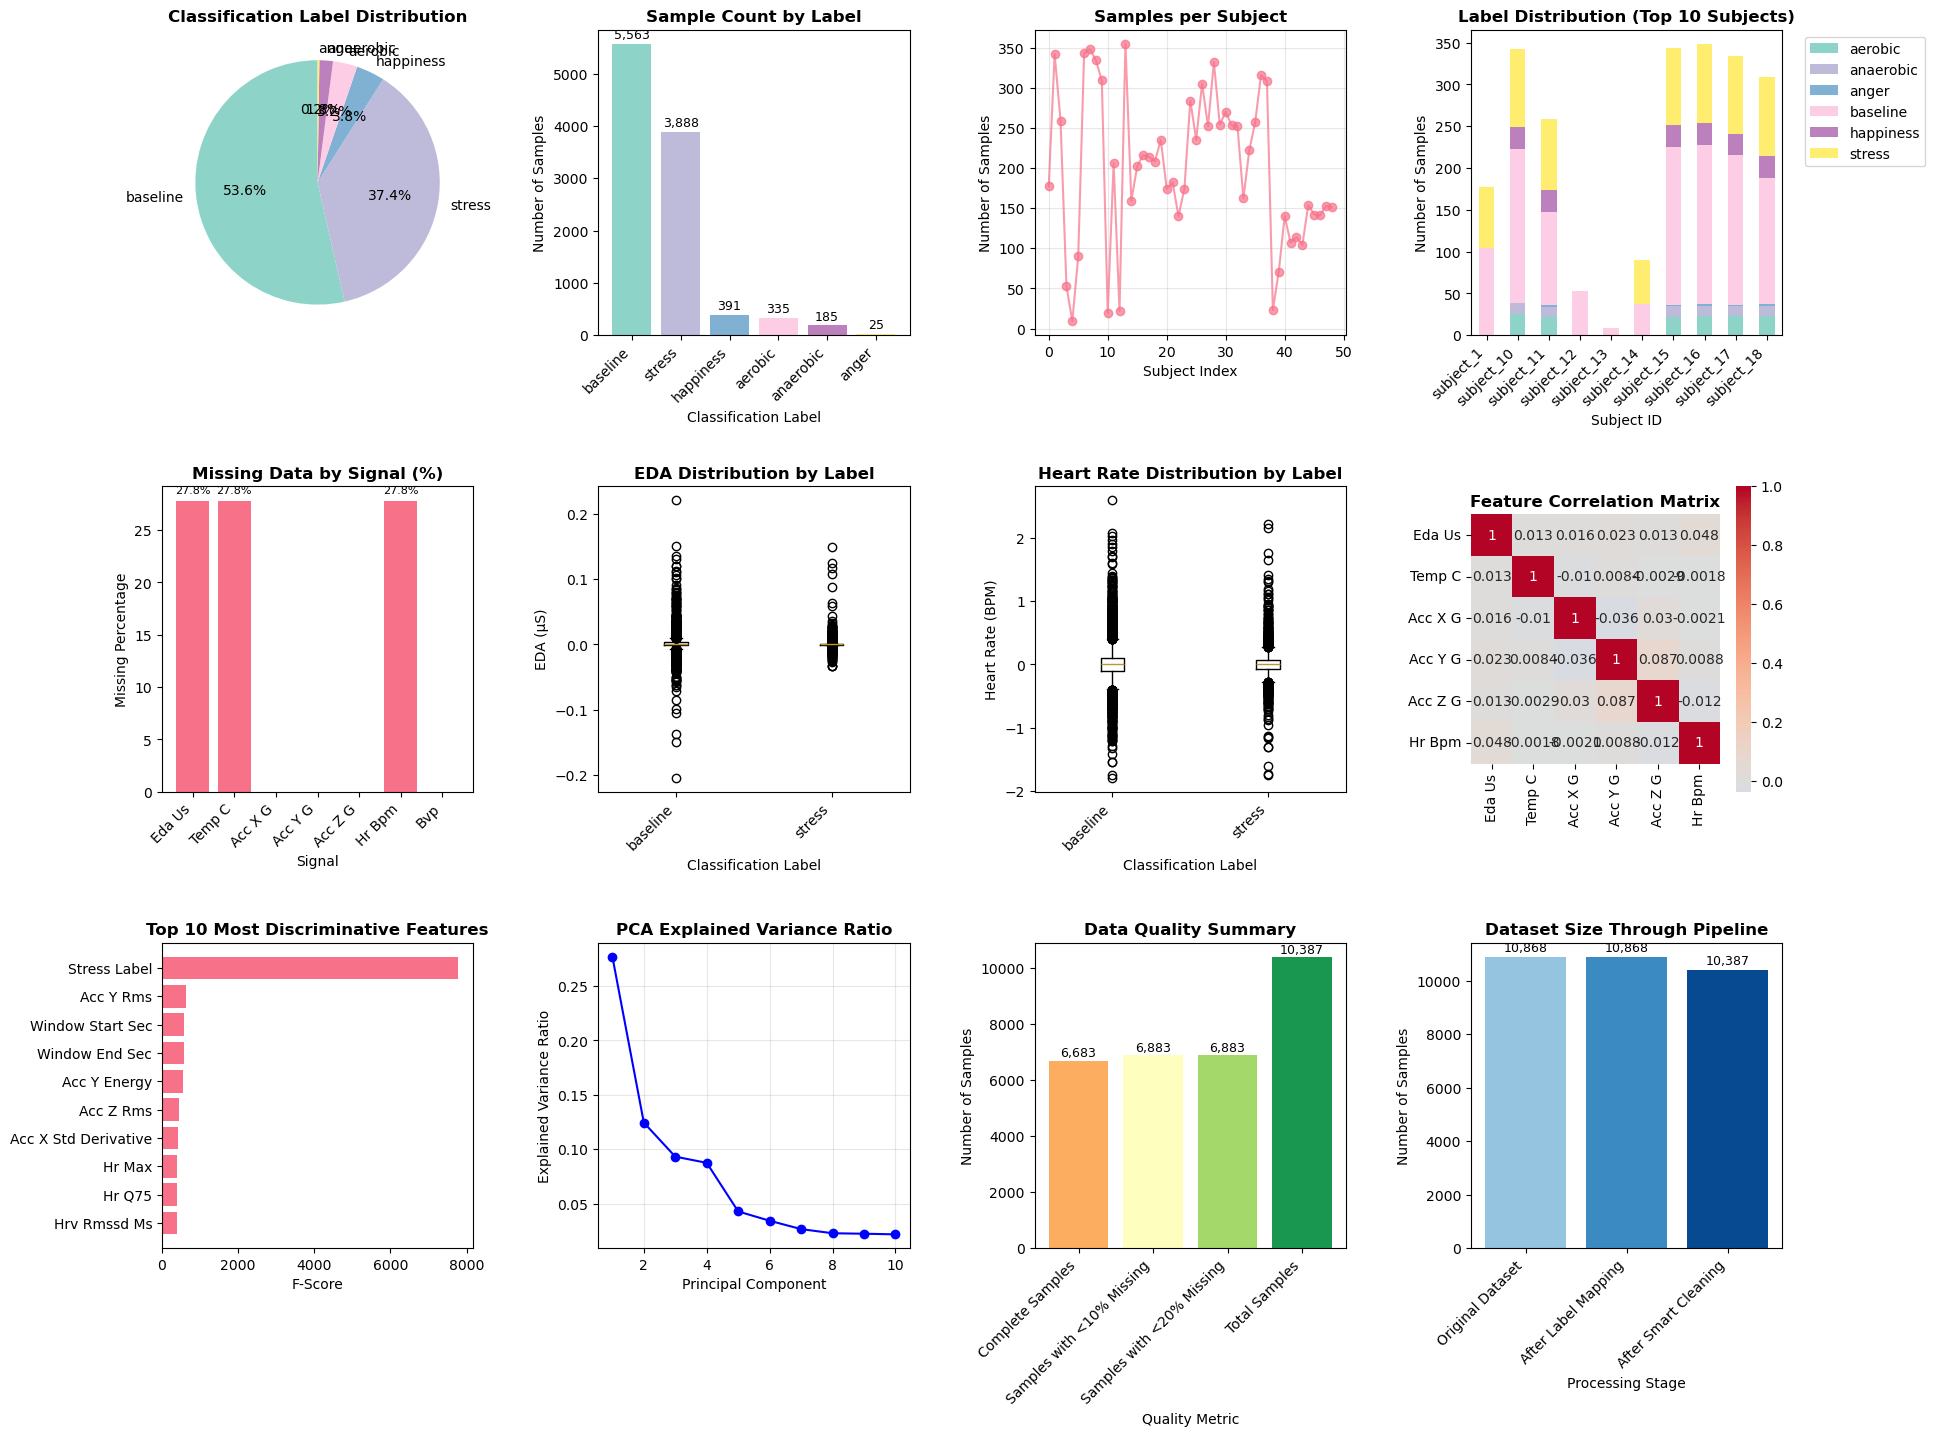


5. FINAL SUMMARY STATISTICS
Dataset Overview:
  Total Samples: 10,387
  Total Features: 109
  Total Subjects: 49
  Missing Percentage: 29.91%

Classification Labels:
  baseline: 5,563 (53.6%)
  stress: 3,888 (37.4%)
  happiness: 391 (3.8%)
  aerobic: 335 (3.2%)
  anaerobic: 185 (1.8%)
  anger: 25 (0.2%)

Data Quality Metrics:
  Complete Samples: 6,683
  Samples With Minimal Missing: 6,883
  Retention Rate: 95.6%

Feature Analysis:
  Total Physiological Features: 109
  Core Signals Available: 7/7
  Signal Type Breakdown:
    Cardiac: 29
    Eda: 15
    Temperature: 15
    Accelerometer: 46
    Other: 4

 Analysis complete!
 Comprehensive visualization saved to: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/figures/comprehensive_dataset_analysis.png
 Summary statistics saved to: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/figures/final_analysis_summary.json
 Dataset is ready for machine learning classification tasks!


In [37]:
# =============================================================================
# STEP 10: COMPREHENSIVE RESULTS VISUALIZATION AND ANALYSIS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 10)

print("="*80)
print("COMPREHENSIVE DATASET ANALYSIS AND VISUALIZATION")
print("="*80)

# Create output directory for figures
figures_dir = OUTPUT_DIR / 'figures'
figures_dir.mkdir(exist_ok=True)

# =============================================================================
# 1. DATASET OVERVIEW STATISTICS
# =============================================================================

print("\n" + "="*60)
print("1. DATASET OVERVIEW")
print("="*60)

# Basic statistics
print(f"Final Dataset Shape: {cleaned_dataset_smart.shape}")
print(f"Total Samples: {cleaned_dataset_smart.shape[0]:,}")
print(f"Total Features: {cleaned_dataset_smart.shape[1]}")
print(f"Subjects: {cleaned_dataset_smart['subject_id'].nunique()}")
print(f"Missing Values: {cleaned_dataset_smart.isnull().sum().sum():,} ({(cleaned_dataset_smart.isnull().sum().sum()/(cleaned_dataset_smart.shape[0]*cleaned_dataset_smart.shape[1])*100):.1f}%)")

# Feature type breakdown
physiological_features = [col for col in cleaned_dataset_smart.columns 
                         if pd.api.types.is_numeric_dtype(cleaned_dataset_smart[col]) and
                         col not in ['subject_id', 'original_row_index', 'window_id']]
metadata_features = [col for col in cleaned_dataset_smart.columns if col not in physiological_features]

print(f"\nFeature Breakdown:")
print(f"  Physiological Signals: {len(physiological_features)}")
print(f"  Metadata Columns: {len(metadata_features)}")
print(f"  Metadata: {metadata_features}")

# =============================================================================
# 2. LABEL DISTRIBUTION ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("2. CLASSIFICATION LABEL ANALYSIS")
print("="*60)

# Label distribution
label_counts = cleaned_dataset_smart['classification_label'].value_counts()
print("Label Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(cleaned_dataset_smart)) * 100
    print(f"  {label}: {count:,} samples ({percentage:.1f}%)")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 2.1 Label Distribution Pie Chart
plt.subplot(3, 4, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(label_counts)))
wedges, texts, autotexts = plt.pie(label_counts.values, labels=label_counts.index, 
                                  autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Classification Label Distribution', fontsize=12, fontweight='bold')

# 2.2 Label Distribution Bar Chart
plt.subplot(3, 4, 2)
bars = plt.bar(label_counts.index, label_counts.values, color=colors)
plt.title('Sample Count by Label', fontsize=12, fontweight='bold')
plt.xlabel('Classification Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# 2.3 Samples per Subject
plt.subplot(3, 4, 3)
subject_counts = cleaned_dataset_smart['subject_id'].value_counts().sort_index()
plt.plot(range(len(subject_counts)), subject_counts.values, 'o-', alpha=0.7)
plt.title('Samples per Subject', fontsize=12, fontweight='bold')
plt.xlabel('Subject Index')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)

# 2.4 Label Distribution by Subject (stacked bar for top 10 subjects)
plt.subplot(3, 4, 4)
top_subjects = subject_counts.head(10).index
subset_data = cleaned_dataset_smart[cleaned_dataset_smart['subject_id'].isin(top_subjects)]
label_by_subject = subset_data.groupby(['subject_id', 'classification_label']).size().unstack(fill_value=0)

label_by_subject.plot(kind='bar', stacked=True, ax=plt.gca(), 
                     color=colors[:len(label_counts)])
plt.title('Label Distribution (Top 10 Subjects)', fontsize=12, fontweight='bold')
plt.xlabel('Subject ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# =============================================================================
# 3. PHYSIOLOGICAL SIGNAL ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("3. PHYSIOLOGICAL SIGNAL ANALYSIS")
print("="*60)

# Get core physiological signals for analysis
core_signals = ['eda_us', 'temp_c', 'acc_x_g', 'acc_y_g', 'acc_z_g', 'hr_bpm', 'bvp']
available_core_signals = [col for col in core_signals if col in cleaned_dataset_smart.columns]
print(f"Analyzing {len(available_core_signals)} core physiological signals: {available_core_signals}")

# 3.1 Signal Quality Analysis (Missing Values)
plt.subplot(3, 4, 5)
signal_missing = cleaned_dataset_smart[available_core_signals].isnull().sum()
signal_missing_pct = (signal_missing / len(cleaned_dataset_smart)) * 100
bars = plt.bar(range(len(signal_missing)), signal_missing_pct.values)
plt.title('Missing Data by Signal (%)', fontsize=12, fontweight='bold')
plt.xlabel('Signal')
plt.ylabel('Missing Percentage')
plt.xticks(range(len(signal_missing)), [col.replace('_', ' ').title() for col in signal_missing.index], rotation=45, ha='right')
for bar, pct in zip(bars, signal_missing_pct.values):
    if pct > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

# 3.2 Signal Distribution by Label (Box Plot for EDA)
plt.subplot(3, 4, 6)
if 'eda_us' in cleaned_dataset_smart.columns:
    eda_data = []
    eda_labels = []
    for label in label_counts.index:
        data = cleaned_dataset_smart[cleaned_dataset_smart['classification_label'] == label]['eda_us'].dropna()
        if len(data) > 10:  # Only include if we have enough data
            eda_data.append(data.values)
            eda_labels.append(label)
    
    if eda_data:
        plt.boxplot(eda_data, labels=eda_labels)
        plt.title('EDA Distribution by Label', fontsize=12, fontweight='bold')
        plt.xlabel('Classification Label')
        plt.ylabel('EDA (μS)')
        plt.xticks(rotation=45, ha='right')

# 3.3 Heart Rate Distribution by Label
plt.subplot(3, 4, 7)
if 'hr_bpm' in cleaned_dataset_smart.columns:
    hr_data = []
    hr_labels = []
    for label in label_counts.index:
        data = cleaned_dataset_smart[cleaned_dataset_smart['classification_label'] == label]['hr_bpm'].dropna()
        if len(data) > 10:
            hr_data.append(data.values)
            hr_labels.append(label)
    
    if hr_data:
        plt.boxplot(hr_data, labels=hr_labels)
        plt.title('Heart Rate Distribution by Label', fontsize=12, fontweight='bold')
        plt.xlabel('Classification Label')
        plt.ylabel('Heart Rate (BPM)')
        plt.xticks(rotation=45, ha='right')

# 3.4 Feature Correlation Heatmap (subset of features)
plt.subplot(3, 4, 8)
correlation_features = available_core_signals[:6]  # Limit to prevent overcrowding
if len(correlation_features) >= 2:
    corr_data = cleaned_dataset_smart[correlation_features].corr()
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True,
                xticklabels=[col.replace('_', ' ').title() for col in correlation_features],
                yticklabels=[col.replace('_', ' ').title() for col in correlation_features])
    plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

# =============================================================================
# 4. ADVANCED FEATURE ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("4. ADVANCED FEATURE ANALYSIS")
print("="*60)

# Prepare data for feature analysis (remove non-numeric and metadata columns)
feature_cols_for_analysis = [col for col in physiological_features 
                            if col in cleaned_dataset_smart.columns and 
                            cleaned_dataset_smart[col].dtype in ['int64', 'float64'] and
                            not cleaned_dataset_smart[col].isnull().all()]

print(f"Analyzing {len(feature_cols_for_analysis)} features for advanced analysis")

if len(feature_cols_for_analysis) > 10 and 'classification_label' in cleaned_dataset_smart.columns:
    # Prepare feature matrix and labels
    X = cleaned_dataset_smart[feature_cols_for_analysis].fillna(0)  # Fill NaN for analysis
    y = cleaned_dataset_smart['classification_label']
    
    # 4.1 Feature Importance using SelectKBest
    try:
        selector = SelectKBest(f_classif, k=min(15, len(feature_cols_for_analysis)))
        X_selected = selector.fit_transform(X, y)
        feature_scores = selector.scores_
        selected_features = np.array(feature_cols_for_analysis)[selector.get_support()]
        
        # Plot top features
        plt.subplot(3, 4, 9)
        top_indices = np.argsort(feature_scores)[-10:]  # Top 10 features
        top_scores = feature_scores[top_indices]
        top_names = [feature_cols_for_analysis[i] for i in top_indices]
        
        bars = plt.barh(range(len(top_scores)), top_scores)
        plt.title('Top 10 Most Discriminative Features', fontsize=12, fontweight='bold')
        plt.xlabel('F-Score')
        plt.yticks(range(len(top_scores)), [name.replace('_', ' ').title() for name in top_names])
        
        print(f"Top 5 most discriminative features:")
        for i, (name, score) in enumerate(zip(top_names[-5:], top_scores[-5:])):
            print(f"  {i+1}. {name}: {score:.2f}")
    
    except Exception as e:
        print(f"Feature importance analysis failed: {e}")
    
    # 4.2 PCA Analysis
    try:
        plt.subplot(3, 4, 10)
        # Use a subset of features to avoid memory issues
        pca_features = feature_cols_for_analysis[:50] if len(feature_cols_for_analysis) > 50 else feature_cols_for_analysis
        X_pca = cleaned_dataset_smart[pca_features].fillna(0)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_pca)
        
        # Apply PCA
        pca = PCA(n_components=10)
        X_pca_reduced = pca.fit_transform(X_scaled)
        
        # Plot explained variance
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                pca.explained_variance_ratio_, 'bo-')
        plt.title('PCA Explained Variance Ratio', fontsize=12, fontweight='bold')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.grid(True, alpha=0.3)
        
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        print(f"PCA Analysis:")
        print(f"  First 3 components explain {cumulative_variance[2]:.1%} of variance")
        print(f"  First 5 components explain {cumulative_variance[4]:.1%} of variance")
        
    except Exception as e:
        print(f"PCA analysis failed: {e}")

# 4.3 Data Quality Summary
plt.subplot(3, 4, 11)
quality_metrics = {
    'Complete Samples': len(cleaned_dataset_smart.dropna()),
    'Samples with <10% Missing': len(cleaned_dataset_smart[cleaned_dataset_smart[physiological_features].isnull().sum(axis=1) < len(physiological_features) * 0.1]),
    'Samples with <20% Missing': len(cleaned_dataset_smart[cleaned_dataset_smart[physiological_features].isnull().sum(axis=1) < len(physiological_features) * 0.2]),
    'Total Samples': len(cleaned_dataset_smart)
}

labels = list(quality_metrics.keys())
values = list(quality_metrics.values())
colors_quality = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(labels)))

bars = plt.bar(range(len(labels)), values, color=colors_quality)
plt.title('Data Quality Summary', fontsize=12, fontweight='bold')
plt.xlabel('Quality Metric')
plt.ylabel('Number of Samples')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{value:,}', ha='center', va='bottom', fontsize=9)

# 4.4 Dataset Size Comparison
plt.subplot(3, 4, 12)
size_comparison = {
    'Original Dataset': len(enhanced_dataset),
    'After Label Mapping': len(enhanced_dataset_classified),
    'After Smart Cleaning': len(cleaned_dataset_smart)
}

stages = list(size_comparison.keys())
sizes = list(size_comparison.values())
colors_stages = plt.cm.Blues(np.linspace(0.4, 0.9, len(stages)))

bars = plt.bar(range(len(stages)), sizes, color=colors_stages)
plt.title('Dataset Size Through Pipeline', fontsize=12, fontweight='bold')
plt.xlabel('Processing Stage')
plt.ylabel('Number of Samples')
plt.xticks(range(len(stages)), stages, rotation=45, ha='right')

for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{size:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout(pad=3.0)
plt.savefig(figures_dir / 'comprehensive_dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 5. FINAL SUMMARY STATISTICS
# =============================================================================

print("\n" + "="*80)
print("5. FINAL SUMMARY STATISTICS")
print("="*80)

summary_stats = {
    'dataset_overview': {
        'total_samples': len(cleaned_dataset_smart),
        'total_features': len(physiological_features),
        'total_subjects': cleaned_dataset_smart['subject_id'].nunique(),
        'missing_percentage': (cleaned_dataset_smart.isnull().sum().sum() / (cleaned_dataset_smart.shape[0] * cleaned_dataset_smart.shape[1])) * 100
    },
    'label_distribution': dict(cleaned_dataset_smart['classification_label'].value_counts()),
    'data_quality': {
        'complete_samples': len(cleaned_dataset_smart.dropna()),
        'samples_with_minimal_missing': len(cleaned_dataset_smart[cleaned_dataset_smart[physiological_features].isnull().sum(axis=1) < len(physiological_features) * 0.1]),
        'retention_rate': len(cleaned_dataset_smart) / len(enhanced_dataset) * 100
    },
    'feature_summary': {
        'physiological_signals': len(physiological_features),
        'core_signals_available': len([col for col in core_signals if col in cleaned_dataset_smart.columns]),
        'signal_types': {
            'cardiac': len([col for col in physiological_features if any(term in col.lower() for term in ['hr', 'bvp', 'heart'])]),
            'eda': len([col for col in physiological_features if 'eda' in col.lower()]),
            'temperature': len([col for col in physiological_features if 'temp' in col.lower()]),
            'accelerometer': len([col for col in physiological_features if 'acc' in col.lower()]),
            'other': len(physiological_features) - sum([
                len([col for col in physiological_features if any(term in col.lower() for term in ['hr', 'bvp', 'heart'])]),
                len([col for col in physiological_features if 'eda' in col.lower()]),
                len([col for col in physiological_features if 'temp' in col.lower()]),
                len([col for col in physiological_features if 'acc' in col.lower()])
            ])
        }
    }
}

print("Dataset Overview:")
for key, value in summary_stats['dataset_overview'].items():
    if isinstance(value, float):
        print(f"  {key.replace('_', ' ').title()}: {value:.2f}{'%' if 'percentage' in key else ''}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value:,}")

print("\nClassification Labels:")
for label, count in summary_stats['label_distribution'].items():
    percentage = (count / summary_stats['dataset_overview']['total_samples']) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

print("\nData Quality Metrics:")
for key, value in summary_stats['data_quality'].items():
    if isinstance(value, float):
        print(f"  {key.replace('_', ' ').title()}: {value:.1f}{'%' if 'rate' in key else ''}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value:,}")

print("\nFeature Analysis:")
print(f"  Total Physiological Features: {summary_stats['feature_summary']['physiological_signals']}")
print(f"  Core Signals Available: {summary_stats['feature_summary']['core_signals_available']}/{len(core_signals)}")
print("  Signal Type Breakdown:")
for signal_type, count in summary_stats['feature_summary']['signal_types'].items():
    if count > 0:
        print(f"    {signal_type.title()}: {count}")

# Save summary to file
summary_path = figures_dir / 'final_analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print(f"\n Analysis complete!")
print(f" Comprehensive visualization saved to: {figures_dir / 'comprehensive_dataset_analysis.png'}")
print(f" Summary statistics saved to: {summary_path}")
print(" Dataset is ready for machine learning classification tasks!")